# Exploratory Data Analysis Assignment: Models Comparison

## Linear Model, Decision Tree, Random Forest and Boosted Trees

Connect Google Drive, where I will be storing all my checkpoint data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Install and load all necessary libraries.

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

from fancyimpute import KNN, BiScaler, SoftImpute

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


### Define some utility functions

Metric computation and plotting functions.

In [ ]:
def compute_metrics(real, predicted):
  print('Maximum residuals error: ' + str(max_error(real, predicted)))
  print('Mean squared error: ' + str(mean_squared_error(real, predicted)))
  print('Mean absolute error: ' + str(mean_absolute_error(real, predicted)))
  print('R-squared score: ' + str(r2_score(real, predicted)))
  print('Explained variance: ' + str(explained_variance_score(real, predicted)))
  return max_error(real, predicted), \
  mean_squared_error(real, predicted), \
  mean_absolute_error(real, predicted), \
  r2_score(real, predicted), \
  explained_variance_score(real, predicted) \

def plot_residuals_histogram(real, predicted, fig_title, colour = 'tab:blue'):
  diff = real - predicted
  diff.hist(bins = 40, color = colour, edgecolor='black', linewidth=0.3)
  plt.title(fig_title)
  plt.xlabel('Prediction Error')
  plt.ylabel('Frequency')

def plot_residuals_scatter(real, predicted, fig_title, colour = 'tab:blue'):
  plt.rcParams['figure.figsize'] = (6.0, 6.0)
  residuals_df = pd.DataFrame({"predicted": predicted, "true": real})
  residuals_df["residuals"] = residuals_df["true"] - residuals_df["predicted"]
  residuals_df.plot(x = "predicted", y = "residuals", kind = "scatter", title = fig_title, color = colour)

def plot_qq(real, predicted, fig_title, colour = 'tab:blue'):
  fig = plt.figure(figsize = (6,6))
  fig.clf()
  ax = fig.gca()
  residuals_df = pd.DataFrame({"predicted": predicted, "true": real})
  residuals_df["residuals"] = residuals_df["true"] - residuals_df["predicted"]
  sm.qqplot(residuals_df['residuals'], ax = ax, color = colour)
  ax.set_title(fig_title)

def plot_predictions(predictions):
  cn_uniques = predictions['CountryName'].unique()

  for cn in cn_uniques:
    data = predictions[predictions['CountryName'] == cn]
    data['Year'] = data['Year'].astype(int)
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    plt.plot(data['Year'], data['GDP growth (annual %)'], 'k')
    plt.plot(data['Year'], data['Predicted LM'], 'g1')
    plt.plot(data['Year'], data['Predicted DT'], 'm2')
    plt.plot(data['Year'], data['Predicted RF'], 'bx')
    plt.plot(data['Year'], data['Predicted XGB'], 'r+')
    plt.gca().legend(('Actual','Predicted LM', 'Predicted DT', 'Predicted RF', 'Predicted XGB'), loc = 'best')
    plt.xlabel("Years from start of plot")
    plt.ylabel("GDP growth (%)")
    plt.title("Evolution of GDP over time in {}".format(cn))
    plt.show()

## Preprocessing

Load restructured indicators data.

In [ ]:
indicators = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/PML/transposed_indicators.csv')

indicators.shape

(13830, 1346)

Filter out years before 1990.

In [ ]:
indicators.drop(indicators[indicators['Year'] < 1990].index, inplace = True)

Filter out all indicators with a NaN count higher tham 40%.

In [ ]:
corr = indicators.corr()

count = 0

max_percentage_of_nans = -1

prebound_features = []

for idx, val in zip(corr['GDP growth (annual %)'].index, corr['GDP growth (annual %)']):
  if val > 0.1 and 100 * indicators[idx].isna().sum() / indicators.shape[0] < 40:
    prebound_features.append((idx, val))
    if max_percentage_of_nans < 100 * indicators[idx].isna().sum() / indicators.shape[0]:
      max_percentage_of_nans = 100 * indicators[idx].isna().sum() / indicators.shape[0]
    count += 1

In [ ]:
sorted(prebound_features, key = lambda x: x[1], reverse = True)[1:11]

[('GDP per capita growth (annual %)', 0.9727110375634905),
 ('GNI growth (annual %)', 0.8743687586710389),
 ('GNI per capita growth (annual %)', 0.8437299052202456),
 ('Industry, value added (annual % growth)', 0.6886777233258929),
 ('Services, etc., value added (annual % growth)', 0.6623186070497442),
 ('Exports of goods and services (annual % growth)', 0.5447652521364001),
 ('Manufacturing, value added (annual % growth)', 0.49792922797861117),
 ('Imports of goods and services (annual % growth)', 0.41104037675886246),
 ('Household final consumption expenditure (annual % growth)',
  0.41011752640088694),
 ('Household final consumption expenditure per capita growth (annual %)',
  0.3852188668498273)]

In [ ]:
indicators.shape

(6420, 1346)

In [ ]:
columns = indicators.columns

new_columns = []

for column in columns:
  if 100 * indicators[column].isna().sum() / indicators.shape[0] <= max_percentage_of_nans:
    new_columns.append(column)

indicators_filtered = pd.DataFrame(columns = new_columns)

indicators_filtered = indicators[new_columns]

In [ ]:
indicators_filtered.shape

(6420, 337)

Apply kNN imputation on the missing data with k = 3.

In [ ]:
country_names = indicators['CountryName']

indicators_knn_imputed = KNN(k = 3).fit_transform(indicators[indicators.columns[1:]])

In [ ]:
indicators_knn_imputed = pd.DataFrame(data = indicators_knn_imputed, columns = indicators.columns[1:])

indicators_knn_imputed.insert(0, 'CountryName', country_names)

cn = [i for i in country_names]

country_names = pd.Series(cn)

indicators_knn_imputed['CountryName'] = country_names

In [ ]:
indicators_knn_imputed.shape

(6420, 1346)

In [ ]:
indicators_knn_imputed = indicators_knn_imputed[indicators_filtered.columns]

In [ ]:
indicators_knn_imputed.shape

(6420, 337)

For every sample in the dataset, use the GDP growth per capita from the previous year. Thus, the 2015 sample with have the 2014 growth per capita and so on and so forth.

In [ ]:
remember_olde = 0

first_flag = True

last_year = 0

for index, row in indicators_knn_imputed[::-1].iterrows():
  if (last_year == 1990 or first_flag == True) and row['Year'] in [2014, 2015]:
    remember_olde = row['GDP per capita growth (annual %)']
    first_flag = False
  last_year = row['Year']
  remember_new = row['GDP per capita growth (annual %)']
  indicators_knn_imputed.at[index, 'GDP per capita growth (annual %)'] = remember_olde
  remember_olde = remember_new

Create checkpoint .csv file with the imputed data.

In [ ]:
indicators_knn_imputed.to_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_knn_imputed.csv', index = False)

Load checkpoint .csv file with the imputed data.

In [ ]:
indicators_knn_imputed = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_knn_imputed.csv')

## 1. Use Random Forest to perform feature selection
---

### Feature Selection

Split data into predictors and predicted and train the Random Forest model on it.

In [ ]:
X_train = indicators_knn_imputed.drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_train = indicators_knn_imputed['GDP growth (annual %)']

In [ ]:
rfr_selector = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=490,
                      max_features=330, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=52, min_samples_split=251,
                      min_weight_fraction_leaf=0.0, n_estimators=1300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

rfr_selector.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=490,
                      max_features=330, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=52, min_samples_split=251,
                      min_weight_fraction_leaf=0.0, n_estimators=1300,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Text(0.5, 1.0, "Coefficients' importance as chosen by the random forest model (15:29)")

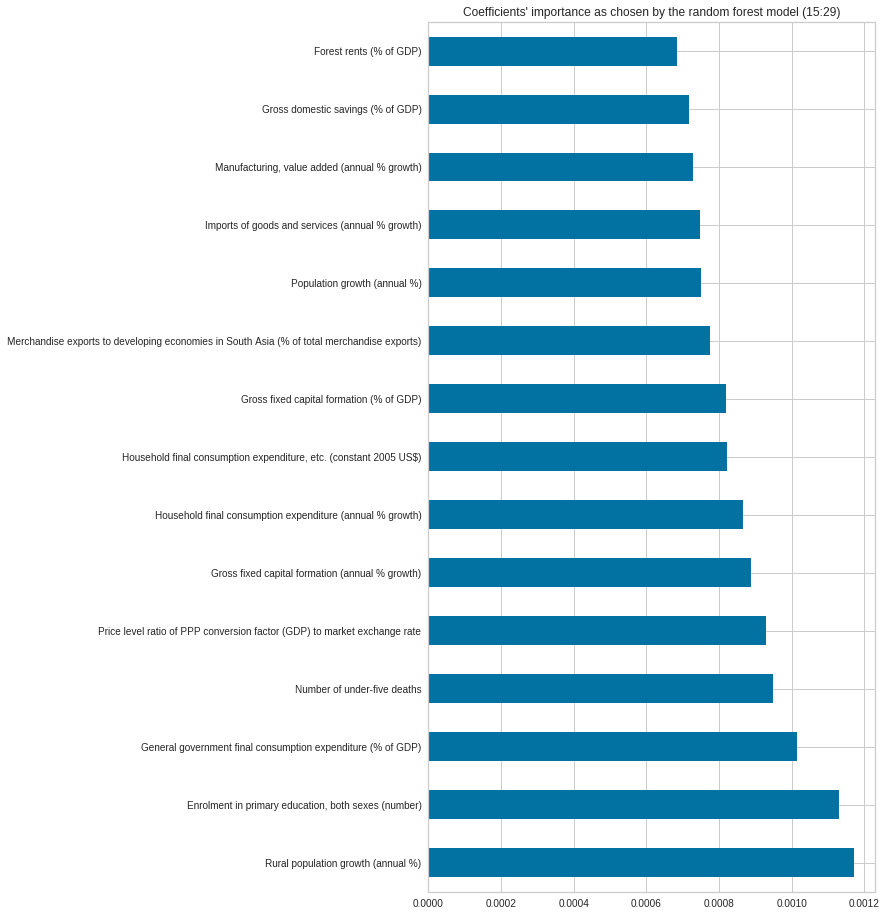

In [ ]:
coefs = pd.Series(rfr_selector.feature_importances_, index = X_train.columns)

coefs.sort_values(ascending = False, inplace = True)

coefs_for_plot = coefs[15:30]

plt.rcParams['figure.figsize'] = (8.0, 16.0)
coefs_for_plot.plot(kind = "barh")
plt.title("Coefficients' importance as chosen by the random forest model (15:29)")

Calculate the preffered sum of scores and filter the features by it.

In [ ]:
s = 0
for elem in coefs[:37]:
  s += elem
print(s)

0.9703231572149003


In [ ]:
coefs = pd.Series(rfr_selector.feature_importances_, index = X_train.columns)

coefs.sort_values(ascending = False, inplace = True)

coefs = coefs[:37]

columns_srf = coefs.index \
                .insert(0, 'CountryName') \
                .insert(1, 'Year') \
                .insert(2, 'GDP growth (annual %)')

Create checkpoint file with selected features.

In [ ]:
with open('/content/gdrive/My Drive/An 1 Masters/EDA/rf_chosen_columns.txt', 'w') as f:
    for col in columns_srf:
        f.write("%s\n" % col)

Load checkpoint file with selected features.

In [ ]:
columns_srf = [line.rstrip('\n') for line in open('/content/gdrive/My Drive/An 1 Masters/EDA/Project/rf_chosen_columns.txt')]

Filter features.

In [ ]:
indicators_filtered = indicators_knn_imputed[columns_srf]

Create mapping from country names to numbers and an inverse mapping as well. Once the country names have been mapped we can apply the outlier removal procedure.

In [ ]:
unique_country_names = indicators_filtered['CountryName'].unique()

cn_map = {}

i = 0

for cn in unique_country_names:
  if cn not in cn_map:
    cn_map[cn] = i
    i += 1

inv_cn_map = {v: k for k, v in cn_map.items()}

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(cn_map)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
indicators_filtered = indicators_filtered[(np.abs(zscore(indicators_filtered)) < 3).all(axis=1)]

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(inv_cn_map)

Use standard scaling to normalize the data.

In [ ]:
columns_fn = indicators_filtered.columns[1:]

country_names = indicators_filtered['CountryName']

years = indicators_filtered['Year']

scaler = StandardScaler()

scaler.fit(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

scaled_indicators = scaler.transform(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

In [ ]:
indicators_fn = pd.DataFrame(data = scaled_indicators, columns = columns_fn)

In [ ]:
indicators_fn['Year'] = years.values

indicators_fn.insert(0, value = country_names.values, column = 'CountryName')

In [ ]:
indicators_fn.shape

(4411, 48)

Create checkpoint .csv for top filled and normalized indicators.


In [ ]:
indicators_fn.to_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_rf.csv', index = False)

Load checkpoint .csv for top filled and normalized indicators.

In [ ]:
indicators_fn = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_rf.csv')

Plot correlation matrix.

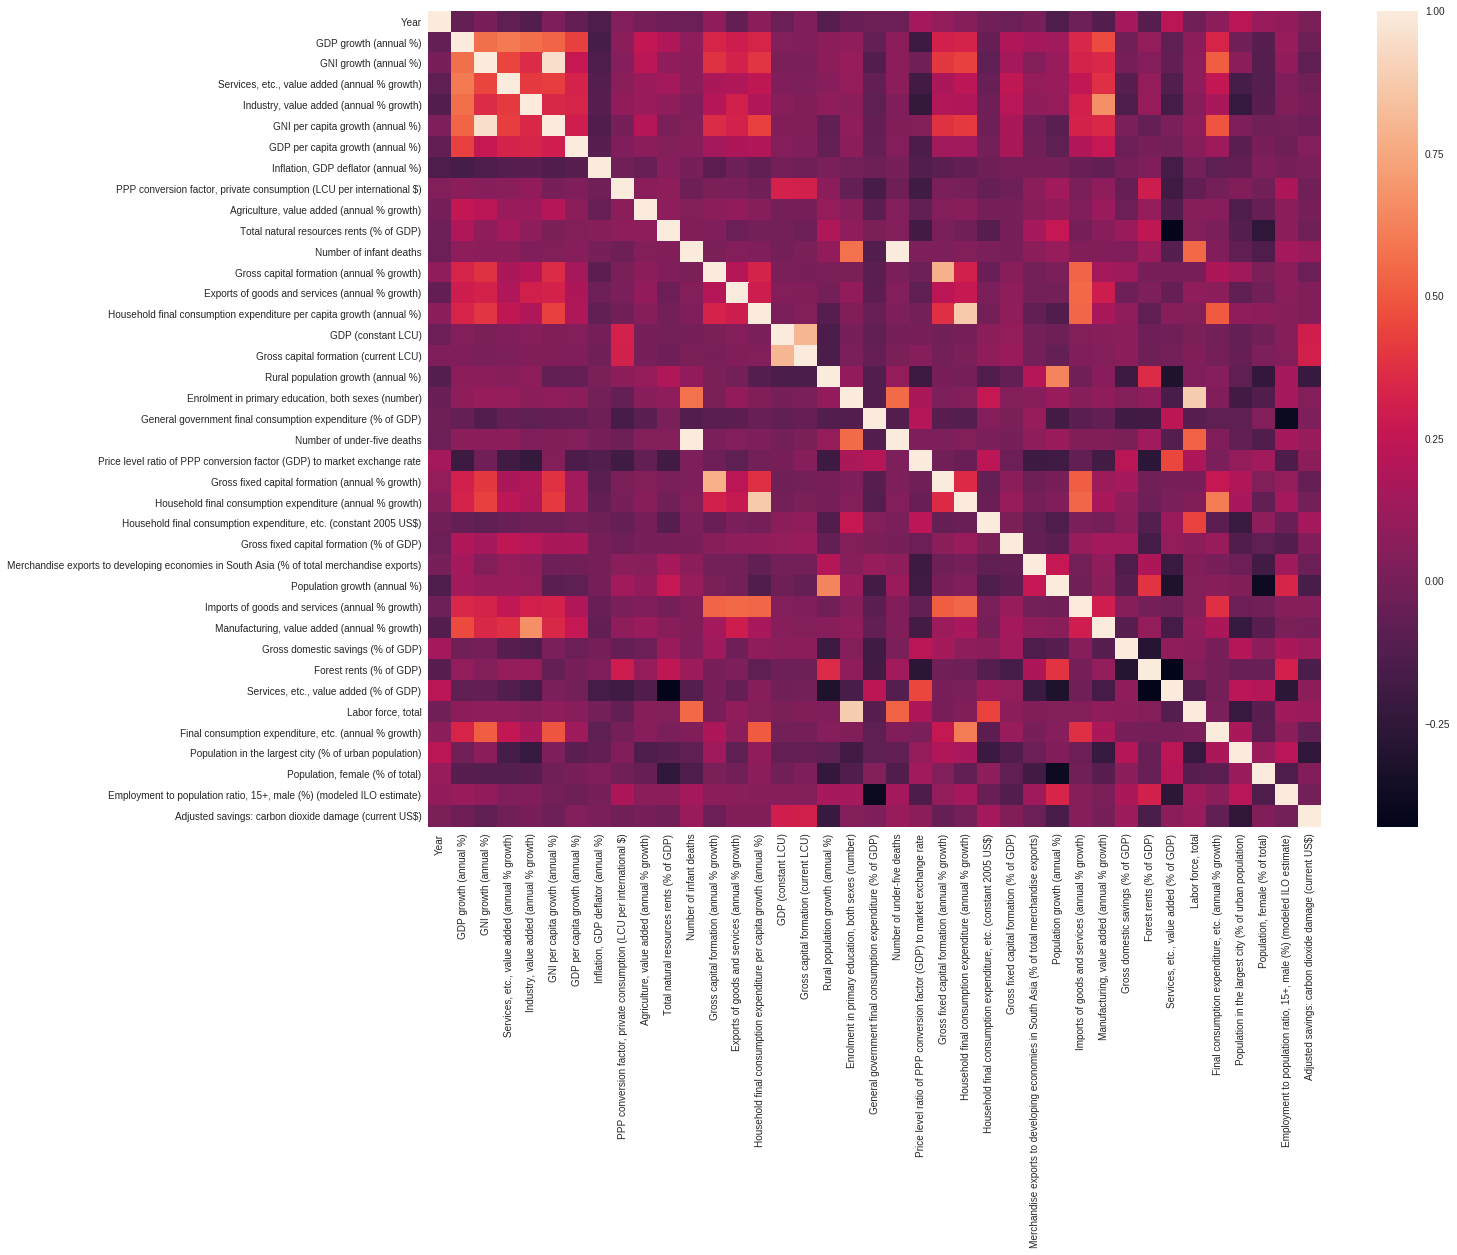

In [ ]:
corr = indicators_fn.corr()

plt.subplots(figsize = (20, 15))

sns.heatmap(corr)

### 1.1 Linear Model

Load checkpoint .csv files with filtered and normalized features and apply a manual train-test split.


In [ ]:
indicators_fn = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_rf.csv')

X_train = indicators_fn[:3898].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_train = indicators_fn[:3898]['GDP growth (annual %)']
X_test = indicators_fn[3898:].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_test = indicators_fn[3898:]['GDP growth (annual %)']

The following few code blocks repeat for each model: 


1.   Instantiate model.
2.   Tune best hyperparameters when necessary.
3.   Fit and predict.
4.   Calculate metrics.
5.   Plot residuals histogram, scatter and QQ-Normal plots.



In [ ]:
lm = LinearRegression()

lm.fit(X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predicted_lm = lm.predict(X_test)

In [ ]:
metrics_lm = compute_metrics(y_test, predicted_lm)

Maximum residuals error: 4.629410402773716
Mean squared error: 0.2563803054594948
Mean absolute error: 0.31776113376635695
R-squared score: 0.7572239561565803
Explained variance: 0.7572239561565803


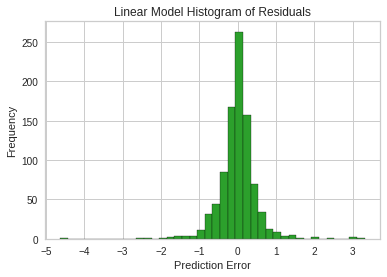

In [ ]:
plot_residuals_histogram(y_test, predicted_lm, 'Linear Model Histogram of Residuals', colour = 'tab:green')

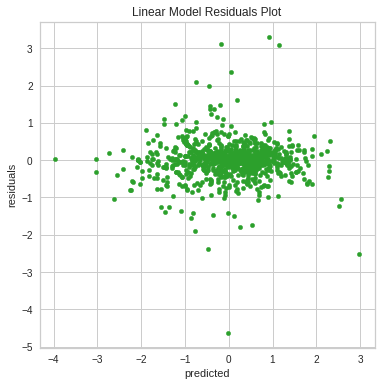

In [ ]:
plot_residuals_scatter(y_test, predicted_lm, 'Linear Model Residuals Plot', colour = 'tab:green')

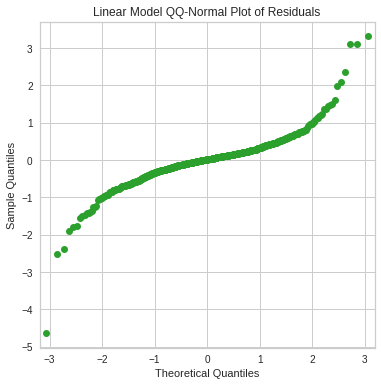

In [ ]:
plot_qq(y_test, predicted_lm, 'Linear Model QQ-Normal Plot of Residuals', colour = 'tab:green')

### 1.2 Decision Tree


In [ ]:
parameters_cv_dt = {
  'max_depth': range(10, 250),
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

dt_model = DecisionTreeRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(dt_model, 
                                   param_distributions = parameters_cv_dt, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   35.7s remaining:  4.8min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:   38.6s remaining:  2.3min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed:  1.1min remaining:  2.2min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed:  1.2min remaining:   56.8s
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed:  1.2min remaining:   36.5s
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed:  1.4min remaining:   24.9s
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:  1.4min remaining:   11.5s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fbefee866d0>,
                   error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=42,
                                                   splitter='best'),
             

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
DecisionTreeRegressor(criterion='mse', max_depth=230, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=92,
                      min_samples_split=452, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-2.0134679653444936

 Best hyperparameters:
{'min_samples_split': 452, 'min_samples_leaf': 92, 'max_features': 32, 'max_depth': 230}


In [ ]:
dt_model = DecisionTreeRegressor(criterion='mse', max_depth=230, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=92,
                      min_samples_split=452, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

dt_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=230, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=92,
                      min_samples_split=452, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [ ]:
predicted_dt = dt_model.predict(X_test)

In [ ]:
metrics_dt = compute_metrics(y_test, predicted_dt)

Maximum residuals error: 4.535510988837252
Mean squared error: 0.4294611370189139
Mean absolute error: 0.44525294235462404
R-squared score: 0.5933272813483677
Explained variance: 0.5933476145515222


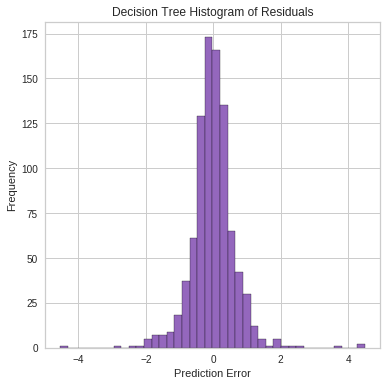

In [ ]:
plot_residuals_histogram(y_test, predicted_dt, 'Decision Tree Histogram of Residuals', colour = 'tab:purple')

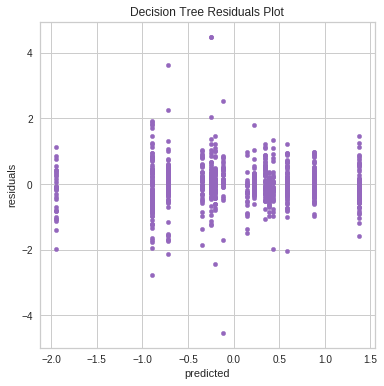

In [ ]:
plot_residuals_scatter(y_test, predicted_dt, 'Decision Tree Residuals Plot', colour = 'tab:purple')

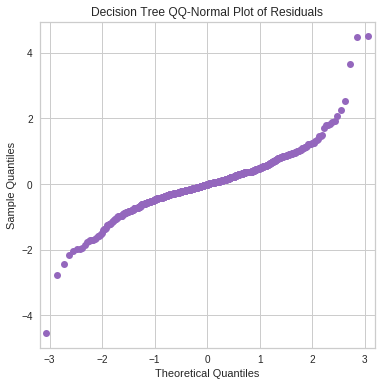

In [ ]:
plot_qq(y_test, predicted_dt, 'Decision Tree QQ-Normal Plot of Residuals', colour = 'tab:purple')

### 1.3 Random Forest



In [ ]:
parameters_cv_rf = {
  'bootstrap': [True],
  'n_estimators': [trees for trees in range(100, 2000, 50)],
  'max_depth': [depth for depth in range(10, 500, 10)],
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

rf_model = RandomForestRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(rf_model, 
                                   param_distributions = parameters_cv_rf, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:  7.6min remaining: 61.3min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed: 15.4min remaining: 54.6min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed: 18.3min remaining: 37.2min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed: 22.9min remaining: 29.2min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed: 27.1min remaining: 22.2min
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed: 29.1min remaining: 15.0min
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed: 31.9min remaining:  9.5min
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed: 32.4min remainin

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f665c7352b0>,
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimato...
                                        'min_samples_leaf': range(2, 100, 5),
    

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.7468069737595977

 Best hyperparameters:
{'n_estimators': 1450, 'min_samples_split': 52, 'min_samples_leaf': 7, 'max_features': 32, 'max_depth': 460, 'bootstrap': True}


In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
predicted_rf = rf_model.predict(X_test)

In [ ]:
metrics_rf = compute_metrics(y_test, predicted_rf)

Maximum residuals error: 4.518404810081064
Mean squared error: 0.26282651713732763
Mean absolute error: 0.3088164655143991
R-squared score: 0.7511197986390337
Explained variance: 0.7514645710469492


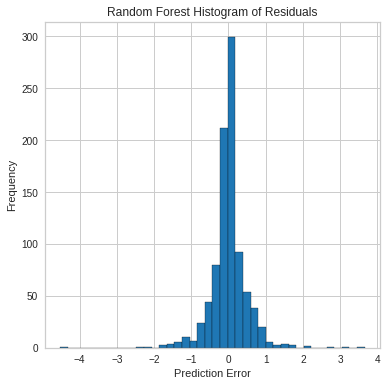

In [ ]:
plot_residuals_histogram(y_test, predicted_rf, 'Random Forest Histogram of Residuals', colour = 'tab:blue')

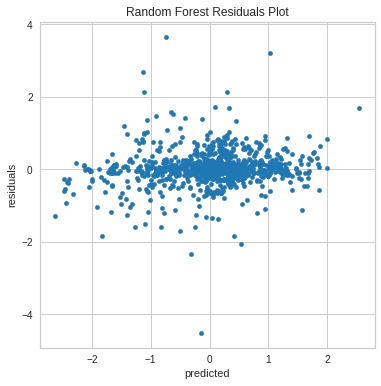

In [ ]:
plot_residuals_scatter(y_test, predicted_rf, 'Random Forest Residuals Plot', colour = 'tab:blue')

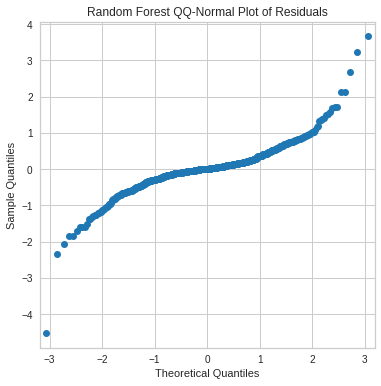

In [ ]:
plot_qq(y_test, predicted_rf, 'Random Forest QQ-Normal Plot of Residuals', colour = 'tab:blue')

### 1.4 Boosted Trees

In [ ]:
parameters_cv_xgb = {
  'booster': ['gbtree', 'gblinear', 'dart'],
  'eta': [0.3, 0.2, 0.1, 0.01, 0.001, 0.0005, 0.0003, 0.0001],
  'max_depth': [depth for depth in range(10, 1000, 10)],
  'max_leaves': [i for i in range(8)],
  'max_delta_step': [i for i in range(10)],
  'gamma': [i / 2 for i in range(1, 20)],
  'subsample': [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [sample / 100 for sample in range(10, 100, 1)],
  'colsample_bylevel': [sample / 100 for sample in range(10, 100, 1)],
  'colsample_bynode': [sample / 100 for sample in range(10, 100, 1)],
  'eval_metric': ['rmse', 'mae', 'logloss'],
  'objective': ['reg:squarederror'],
  'tree_method': ['auto', 'exact']
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

xgb_model = XGBRegressor()

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions = parameters_cv_xgb, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   47.9s remaining:  6.5min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:   49.6s remaining:  2.9min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed:  1.5min remaining:  3.1min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed:  1.6min remaining:  2.0min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed:  2.2min remaining:  1.8min
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed:  3.2min remaining:  1.7min
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed:  4.0min remaining:  1.2min
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:  4.4min remaining:   35.9s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:  4.4min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f665c735620>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs...
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
              

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.99,
             colsample_bynode=0.27, colsample_bytree=0.71, eta=0.01,
             eval_metric='rmse', gamma=0.5, importance_type='gain',
             learning_rate=0.1, max_delta_step=1, max_depth=490, max_leaves=0,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='auto', verbosity=1)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.6362454274343352

 Best hyperparameters:
{'tree_method': 'auto', 'subsample': 0.6, 'objective': 'reg:squarederror', 'max_leaves': 0, 'max_depth': 490, 'max_delta_step': 1, 'gamma': 0.5, 'eval_metric': 'rmse', 'eta': 0.01, 'colsample_bytree': 0.71, 'colsample_bynode': 0.27, 'colsample_bylevel': 0.99, 'booster': 'dart'}


In [ ]:
xgb_model = XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.99,
             colsample_bynode=0.27, colsample_bytree=0.71, eta=0.01,
             eval_metric='rmse', gamma=0.5, importance_type='gain',
             learning_rate=0.1, max_delta_step=1, max_depth=490, max_leaves=0,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='auto', verbosity=1)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.99,
             colsample_bynode=0.27, colsample_bytree=0.71, eta=0.01,
             eval_metric='rmse', gamma=0.5, importance_type='gain',
             learning_rate=0.1, max_delta_step=1, max_depth=490, max_leaves=0,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='auto', verbosity=1)

In [ ]:
predicted_xgb = xgb_model.predict(X_test)

In [ ]:
metrics_xgb = compute_metrics(y_test, predicted_xgb)

Maximum residuals error: 4.7035131470201
Mean squared error: 0.2607290149138957
Mean absolute error: 0.32402901232107884
R-squared score: 0.7531060014826761
Explained variance: 0.7532800418086095


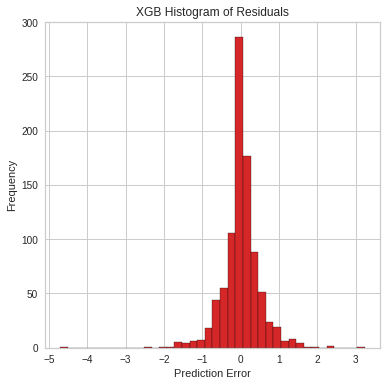

In [ ]:
plot_residuals_histogram(y_test, predicted_xgb, 'XGB Histogram of Residuals', colour = 'tab:red')

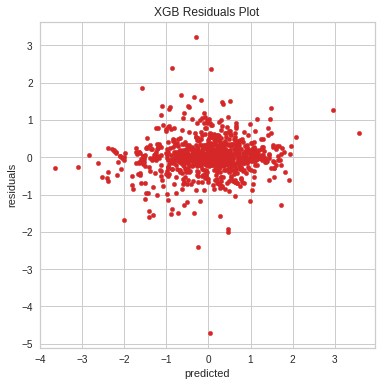

In [ ]:
plot_residuals_scatter(y_test, predicted_xgb, 'XGB Residuals Plot', colour = 'tab:red')

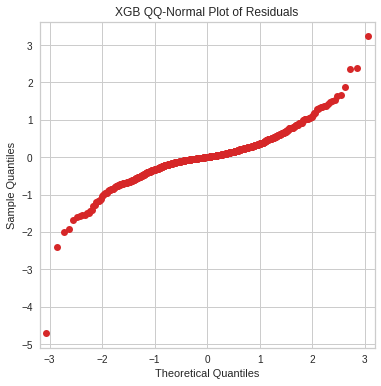

In [ ]:
plot_qq(y_test, predicted_xgb, 'XGB QQ-Normal Plot of Residuals', colour = 'tab:red')

### Plot Metrics

In [ ]:
np.array([np.array(metrics_lm), 
         np.array(metrics_dt), 
         np.array(metrics_rf), 
         np.array(metrics_xgb)])

metrics = pd.DataFrame(data = np.array([np.array(metrics_lm), 
                              np.array(metrics_dt), 
                              np.array(metrics_rf), 
                              np.array(metrics_xgb)]), 
                       columns = ['Maximum Residual Error', 
                                  'Mean Squared Error',
                                  'Mean Absolute Error',
                                  'R^2 Score',
                                  'Explained Variance'], 
                       index = ['Linear Model', 
                                'Decision Tree', 
                                'Random Forest', 
                                'XGBoost'])

metrics

Maximum Residual Error  ...  Explained Variance
Linear Model                 4.629410  ...            0.757224
Decision Tree                4.535511  ...            0.593348
Random Forest                4.518405  ...            0.751465
XGBoost                      4.703513  ...            0.753280

[4 rows x 5 columns]

### Plot Real vs Fitted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


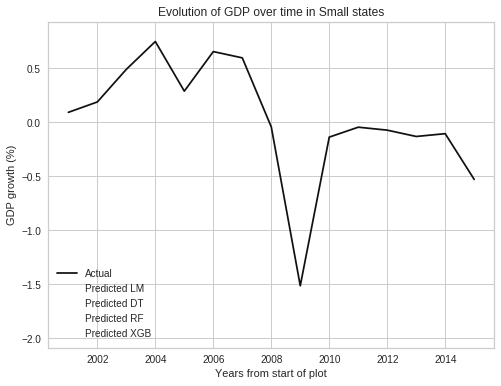

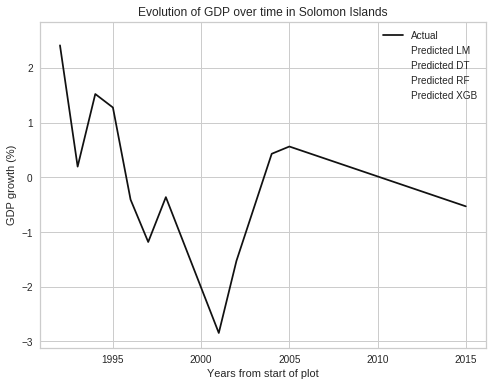

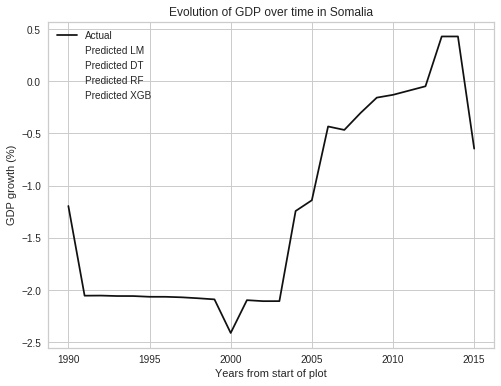

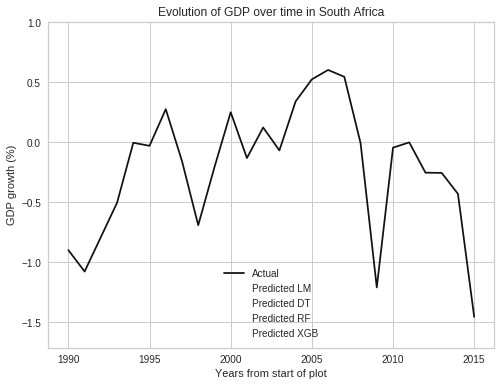

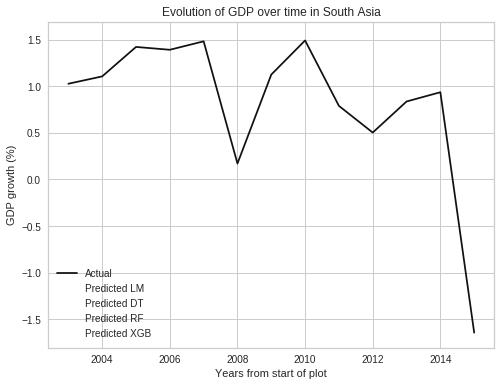

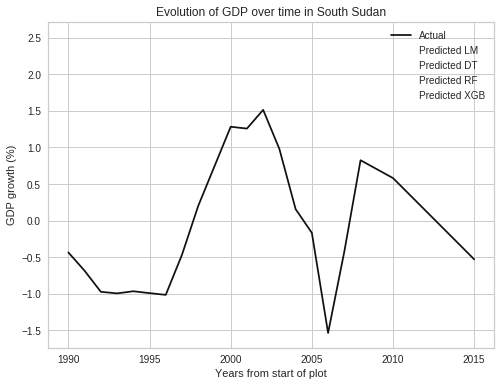

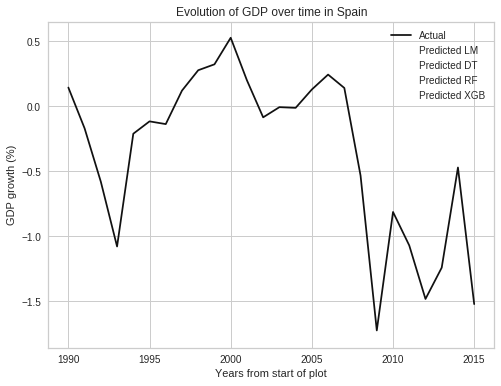

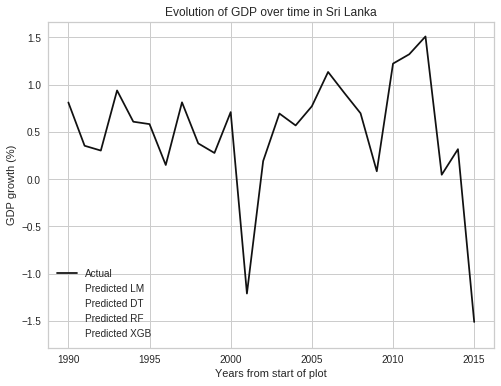

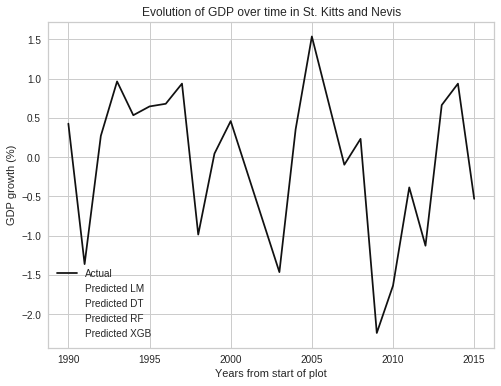

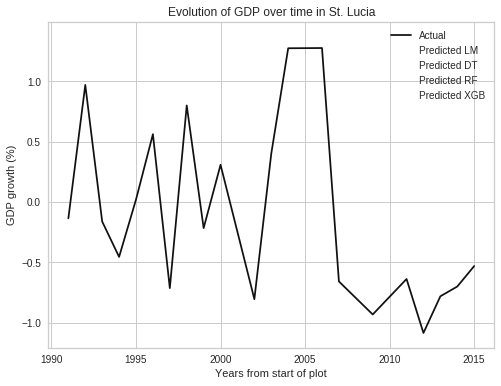

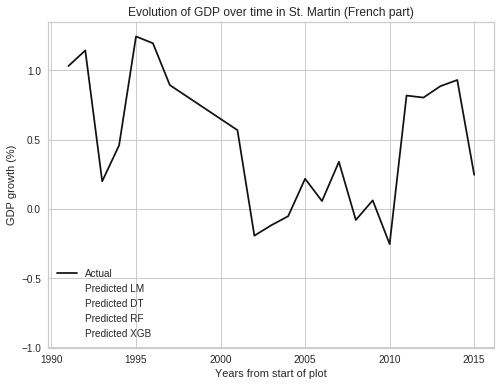

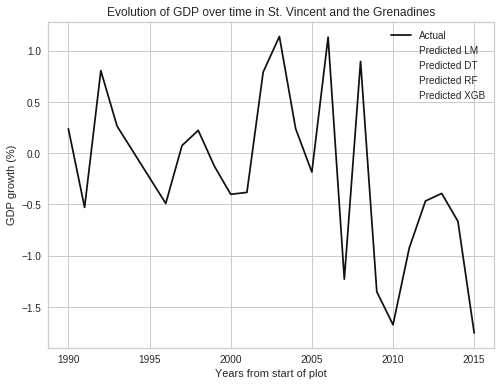

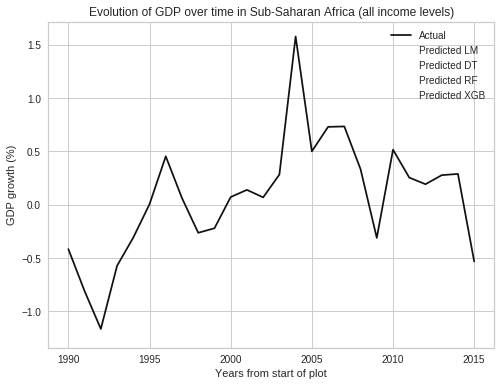

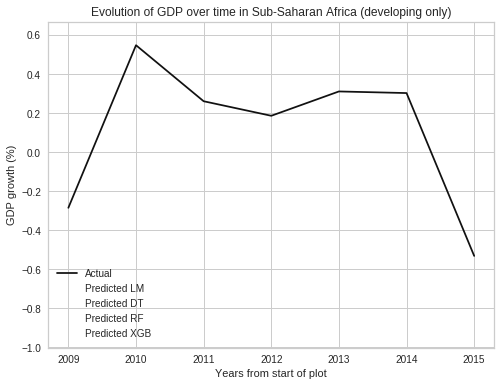

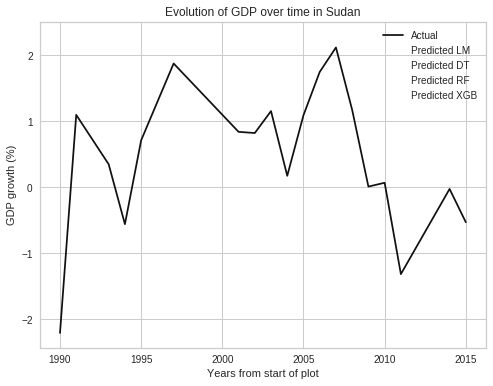

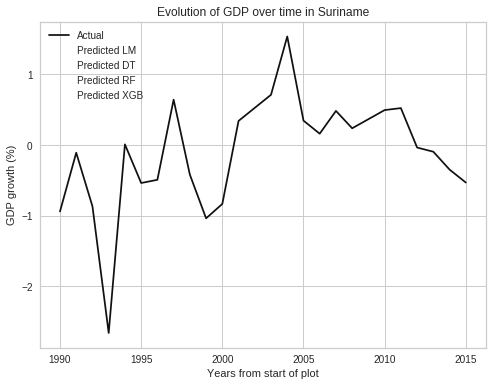

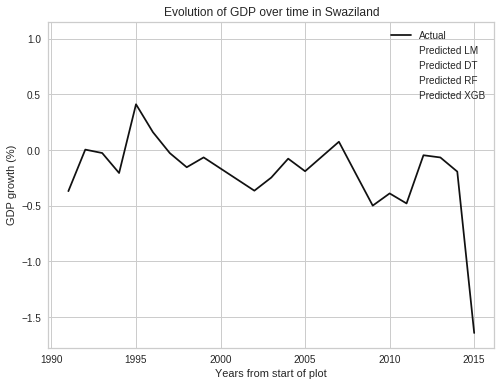

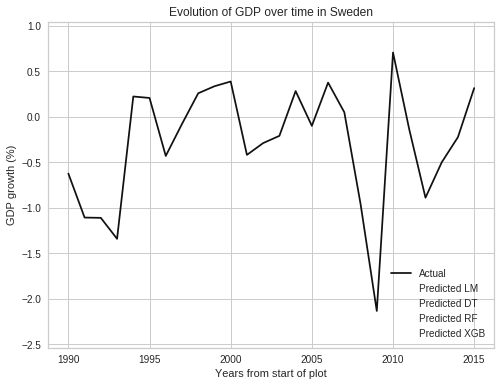

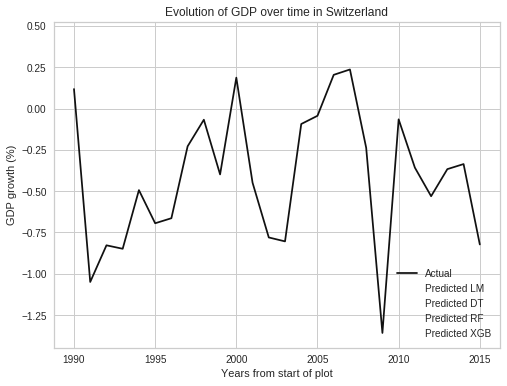

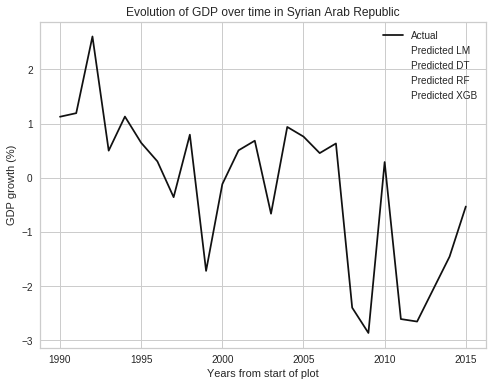

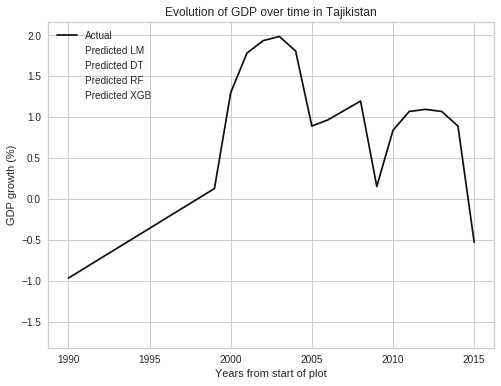

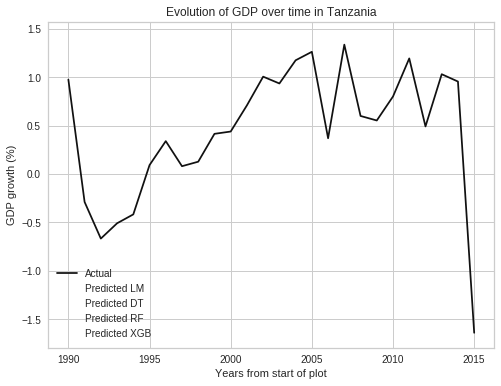

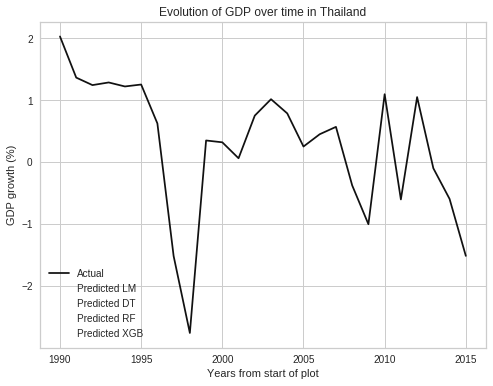

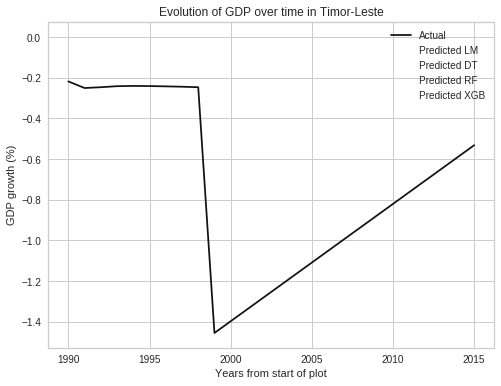

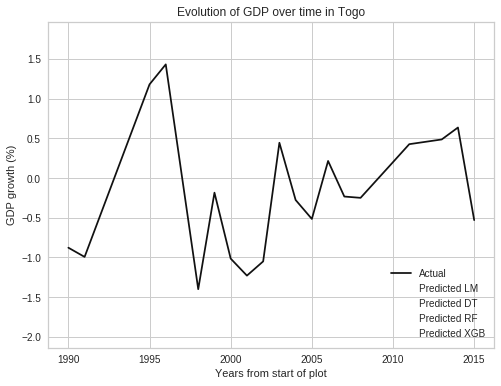

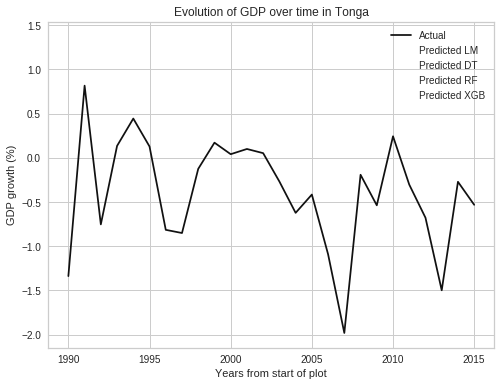

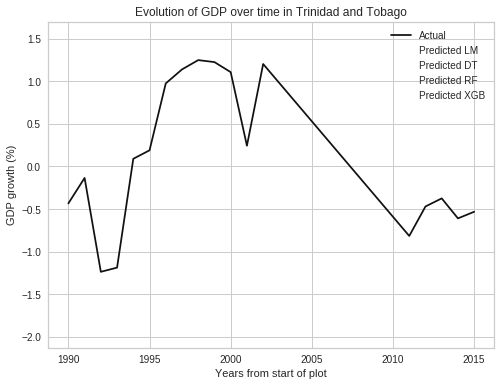

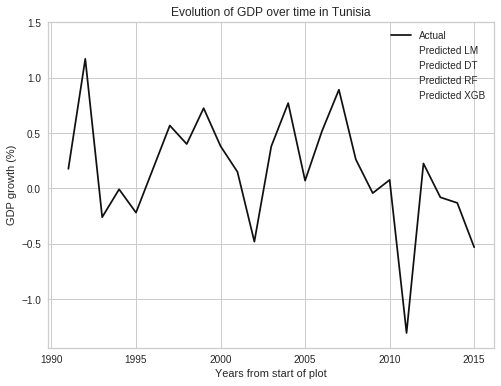

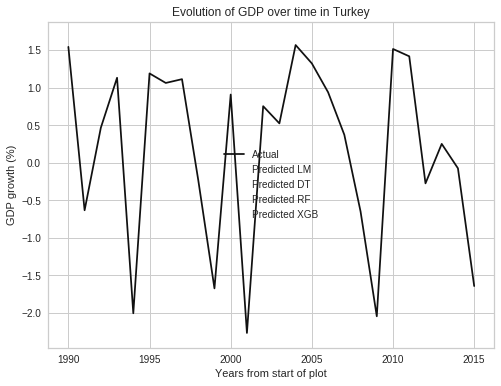

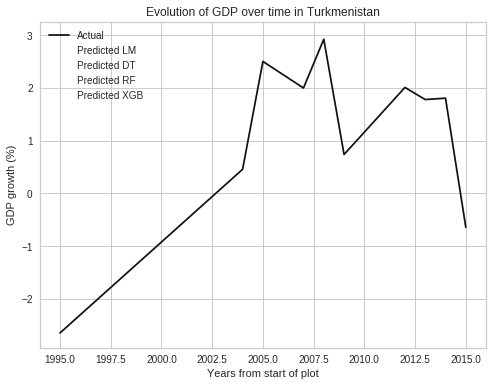

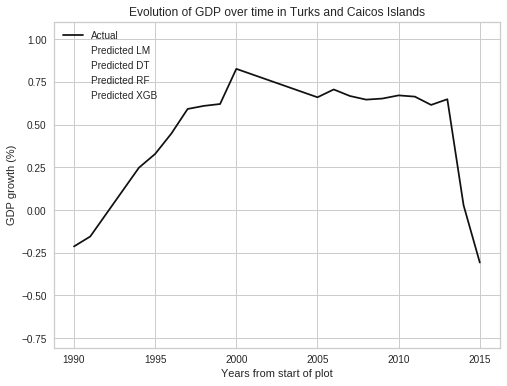

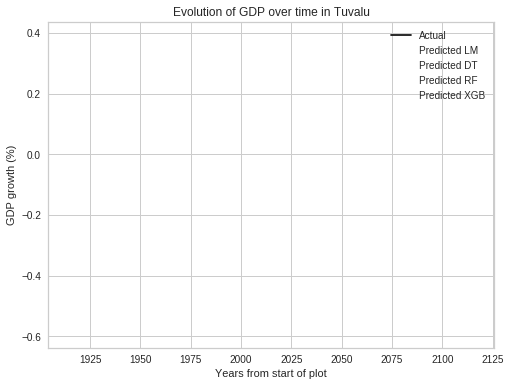

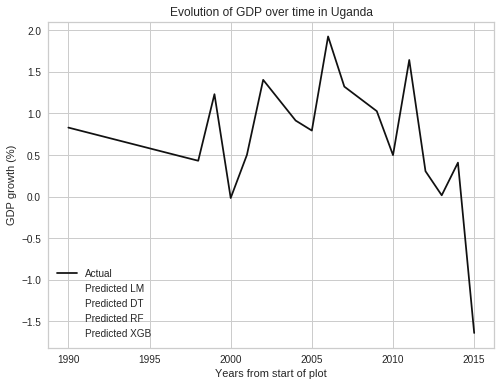

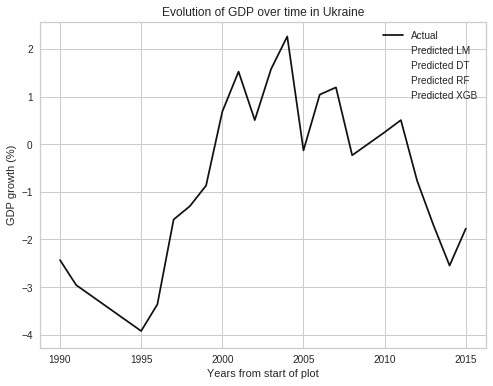

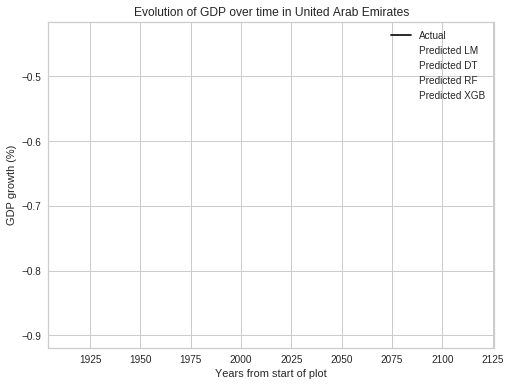

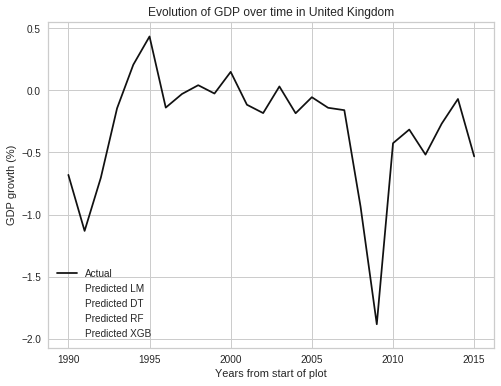

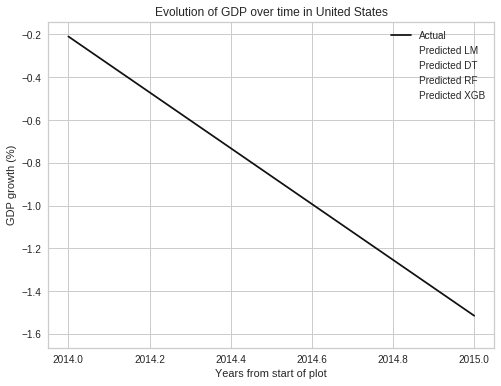

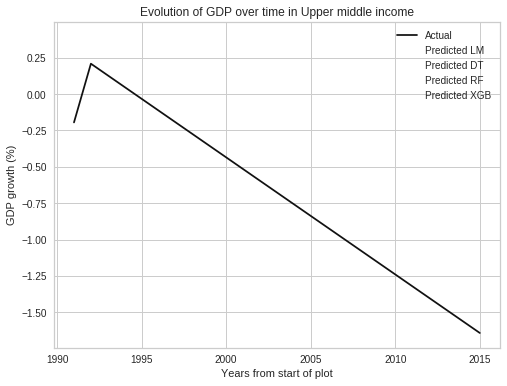

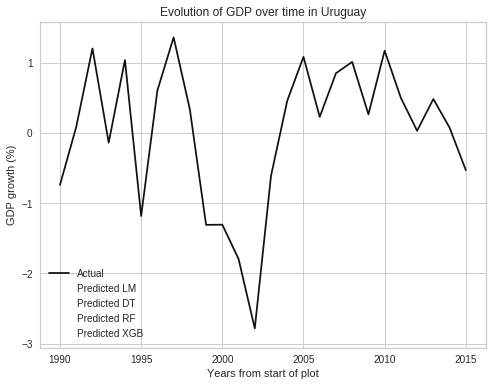

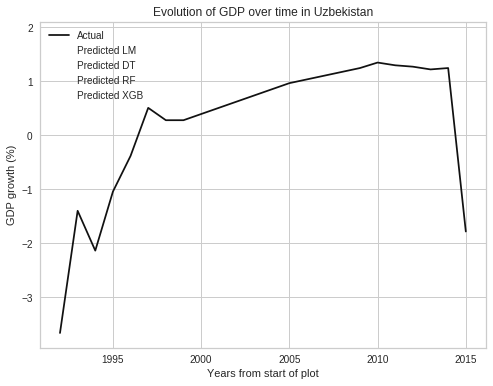

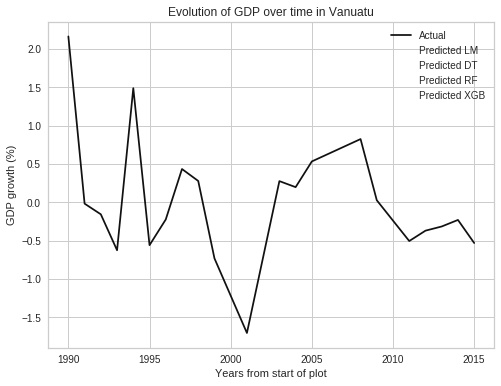

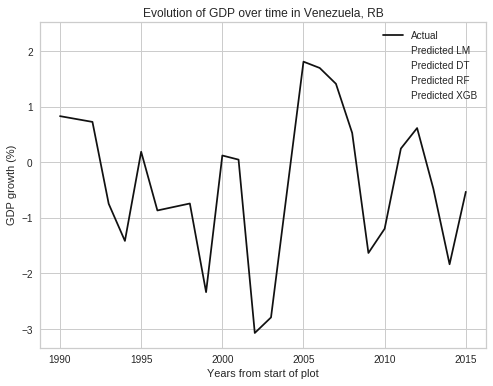

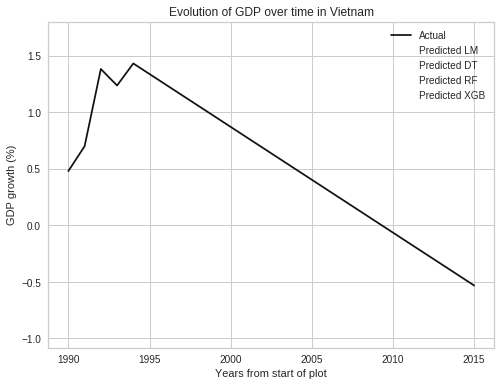

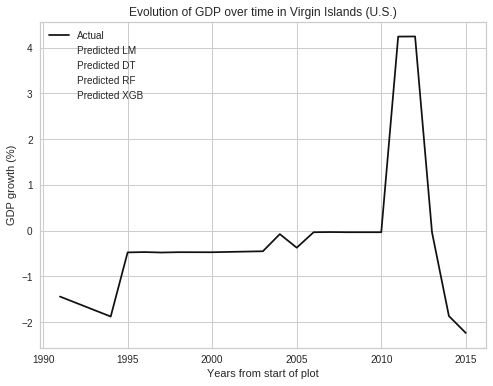

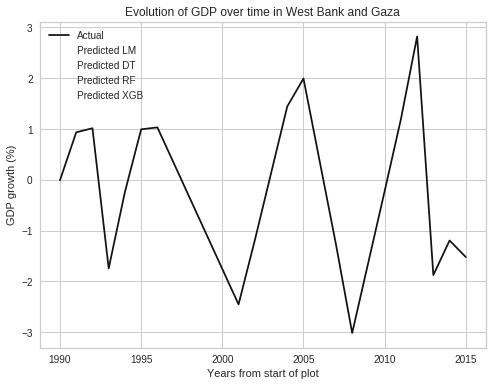

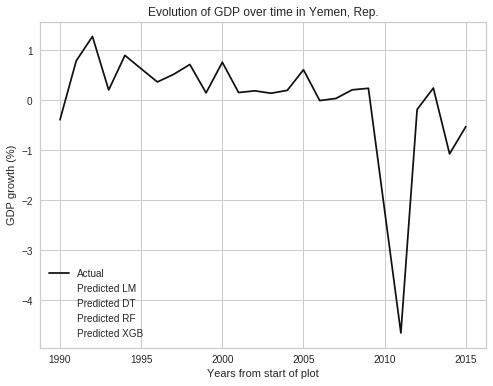

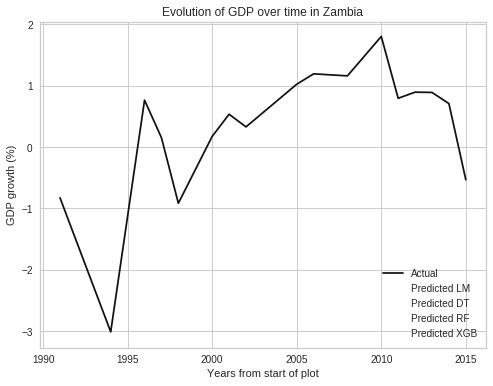

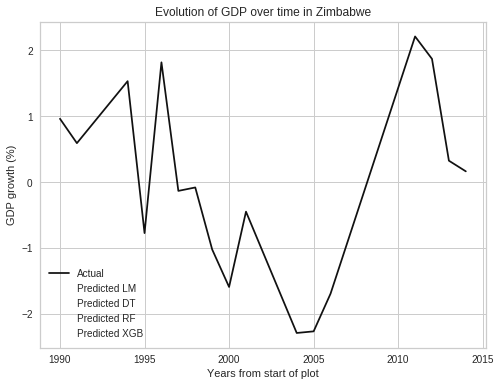

In [ ]:
predictions = pd.DataFrame({'CountryName': indicators_fn[3898:]['CountryName'],
                            'Year': indicators_fn[3898:]['Year'],
                            'GDP growth (annual %)': indicators_fn[3898:]['GDP growth (annual %)'],
                            'Predicted LM': predicted_lm,
                            'Predicted DT': predicted_dt,
                            'Predicted RF': predicted_rf,
                            'Predicted XGB': predicted_xgb})

plot_predictions(predictions)

## 2. Use Lasso to perform feature selection
---



### Feature Selection

Load imputed data and split iata into predictors and predicted and train the Lasso model on it.

In [ ]:
indicators_knn_imputed = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_knn_imputed.csv')

In [ ]:
X_train = indicators_knn_imputed.drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_train = indicators_knn_imputed['GDP growth (annual %)']

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.005, 0.0005], tol = 0.001, selection = 'random', verbose = 0).fit(X_train, y_train)
coefs = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coefs != 0)) + " variables and eliminated the other " +  str(sum(coefs == 0)) + " variables")

Lasso picked 335 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model (1-29)')

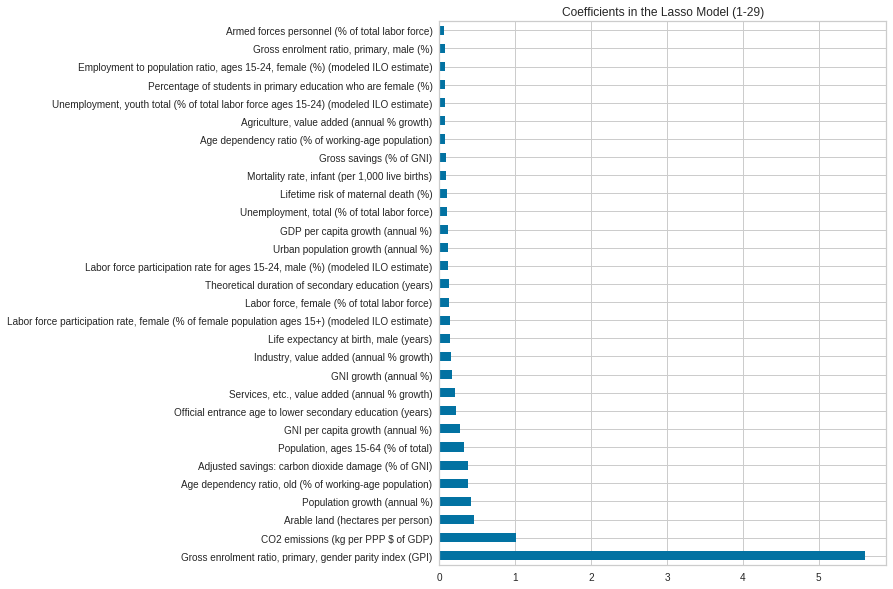

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
coefs.sort_values(ascending = False)[:30].plot(kind = "barh")
plt.title("Coefficients in the Lasso Model (1-29)")

Select the same number of top features as we chose when using the Random Forest model for feature selection.

In [ ]:
coefs = coefs.sort_values(ascending = False)[:37]

In [ ]:
columns_selected_lasso = coefs.index\
                            .insert(0, 'CountryName') \
                            .insert(1, 'Year') \
                            .insert(2, 'GDP growth (annual %)')

Create checkpoint file with selected features.

In [ ]:
with open('/content/gdrive/My Drive/An 1 Masters/EDA/Project/lasso_chosen_columns.txt', 'w') as f:
    for col in columns_selected_lasso:
        f.write("%s\n" % col)

Create mapping from country names to numbers and an inverse mapping as well. Once the country names have been mapped we can apply the outlier removal procedure.

In [ ]:
indicators_filtered = indicators_knn_imputed[columns_selected_lasso]

In [ ]:
unique_country_names = indicators_filtered['CountryName'].unique()

cn_map = {}

i = 0

for cn in unique_country_names:
  if cn not in cn_map:
    cn_map[cn] = i
    i += 1

inv_cn_map = {v: k for k, v in cn_map.items()}

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(cn_map)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
indicators_filtered = indicators_filtered[(np.abs(zscore(indicators_filtered)) < 3).all(axis=1)]

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(inv_cn_map)

Use standard scaling to normalize the data.

In [ ]:
columns_fn = indicators_filtered.columns[1:]

country_names = indicators_filtered['CountryName']

years = indicators_filtered['Year']

scaler = StandardScaler()

scaler.fit(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

scaled_indicators = scaler.transform(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

In [ ]:
indicators_fn = pd.DataFrame(data = scaled_indicators, columns = columns_fn)

In [ ]:
indicators_fn['Year'] = years.values

indicators_fn.insert(0, value = country_names.values, column = 'CountryName')

Create checkpoint .csv for top filled and normalized indicators.

In [ ]:
indicators_fn.to_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_lasso.csv', index = False)

Load checkpoint .csv for top filled and normalized indicators.


In [ ]:
indicators_fn = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_lasso.csv')

Plot correlation matrix.

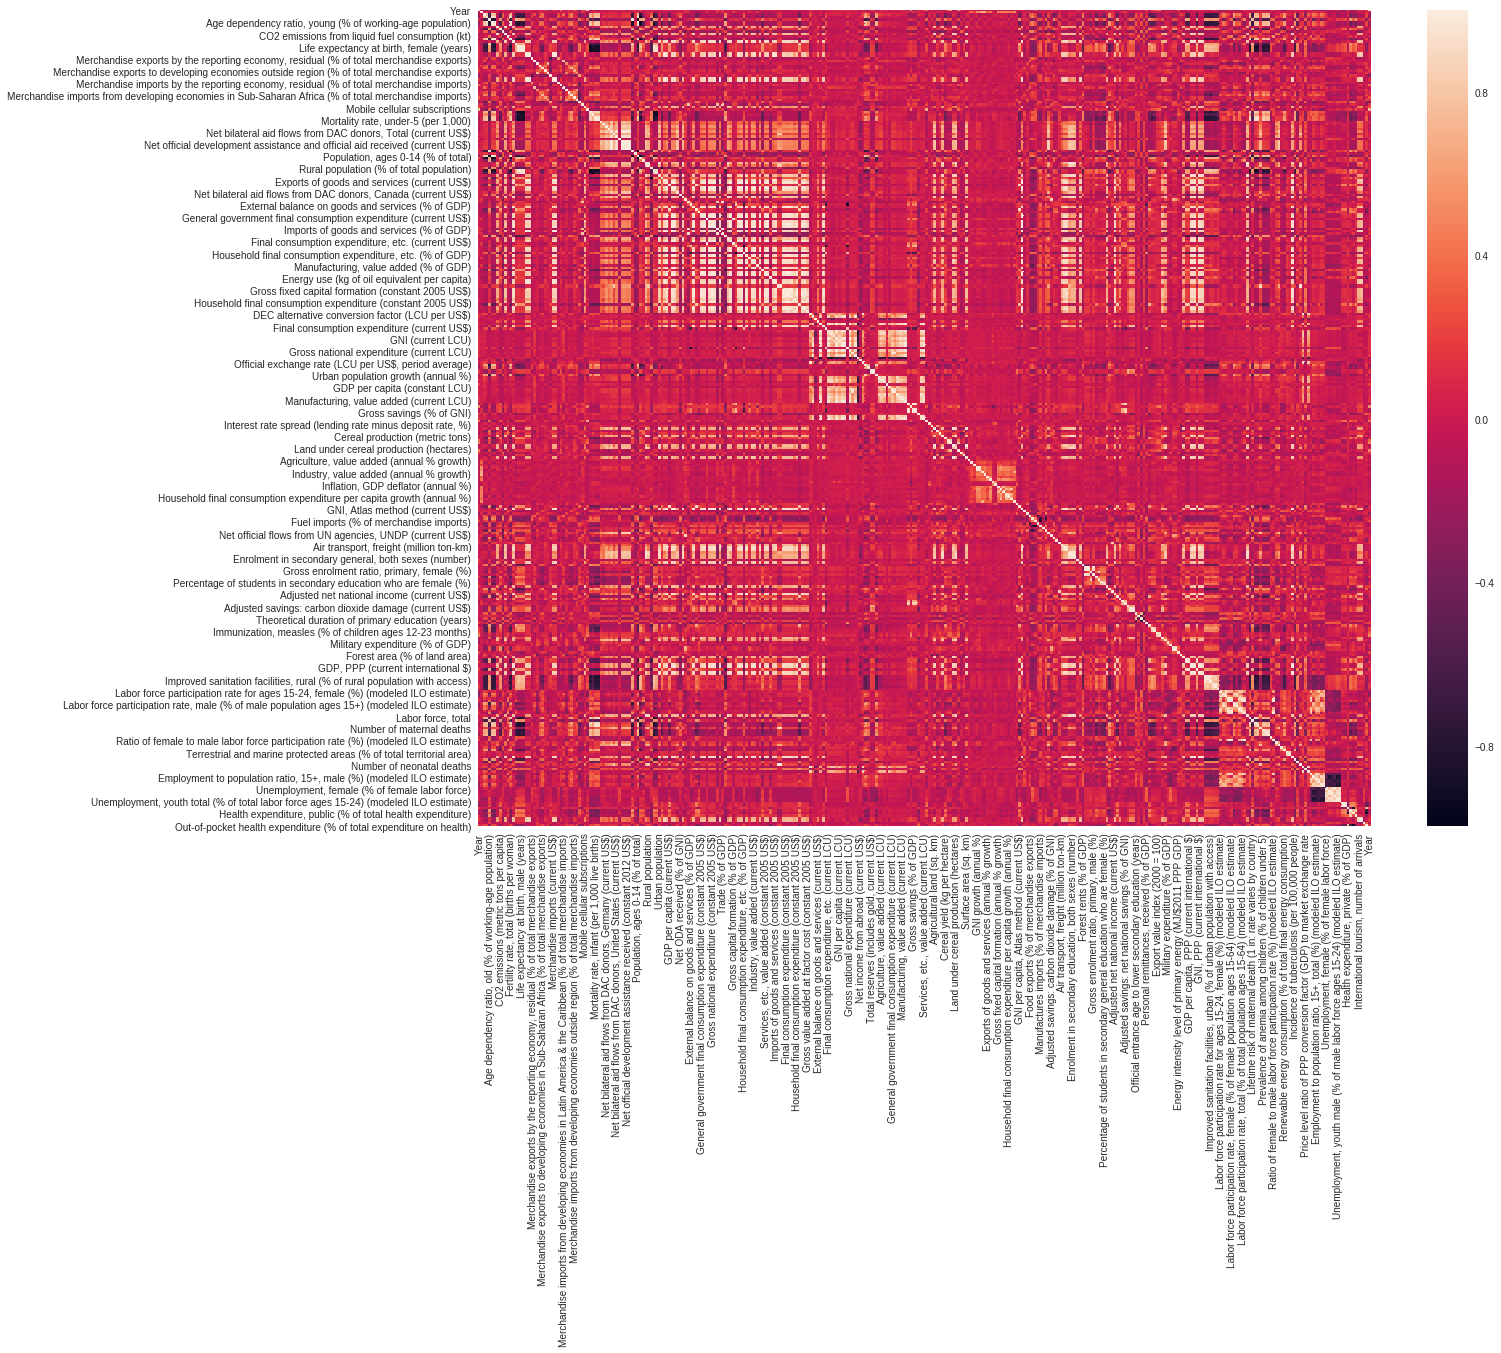

In [ ]:
corr = indicators_fn.corr()

plt.subplots(figsize = (20, 15))

sns.heatmap(corr)

### 2.1 Linear Model

Load checkpoint .csv files with filtered and normalized features and apply a manual train-test split.

In [ ]:
indicators_fn = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/Project/indicators_top40_lasso.csv')

X_train = indicators_fn[:3017].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_train = indicators_fn[:3017]['GDP growth (annual %)']
X_test = indicators_fn[3017:].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_test = indicators_fn[3017:]['GDP growth (annual %)']

The following few code blocks repeat for each model: 


1.   Instantiate model.
2.   Tune best hyperparameters when necessary.
3.   Fit and predict.
4.   Calculate metrics.
5.   Plot residuals histogram, scatter and QQ-Normal plots.



In [ ]:
lm_model = LinearRegression()

lm_model.fit(X_test, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predicted_lm = lm_model.predict(X_test)

In [ ]:
metrics_lm = compute_metrics(y_test, predicted_lm)

Maximum residuals error: 4.974215593192087
Mean squared error: 0.40103780997819094
Mean absolute error: 0.3799039959100856
R-squared score: 0.60161501854286
Explained variance: 0.6016150185428601


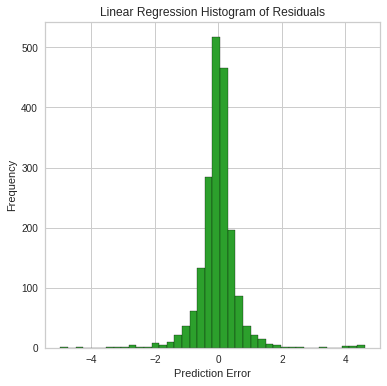

In [ ]:
plot_residuals_histogram(y_test, predicted_lm, 'Linear Regression Histogram of Residuals', colour = 'tab:green')

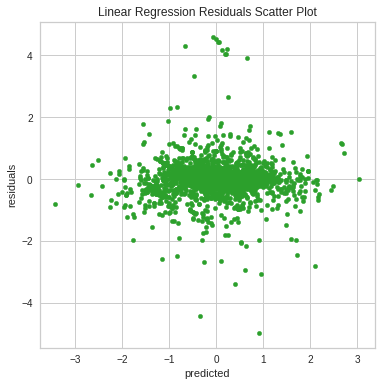

In [ ]:
plot_residuals_scatter(y_test, predicted_lm, 'Linear Regression Residuals Scatter Plot', colour = 'tab:green')

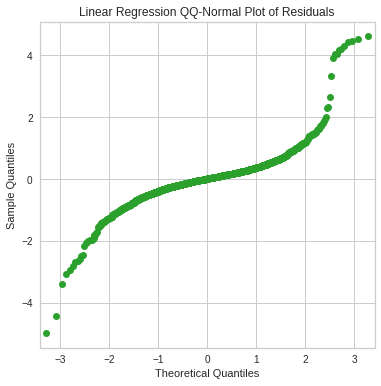

In [ ]:
plot_qq(y_test, predicted_lm, 'Linear Regression QQ-Normal Plot of Residuals', colour = 'tab:green')

### 2.2 Decision Tree

In [ ]:
parameters_cv_dt = {
  'max_depth': range(10, 250),
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

dt_model = DecisionTreeRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(dt_model, 
                                   param_distributions = parameters_cv_dt, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   38.9s remaining:  5.2min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:   41.3s remaining:  2.4min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed:  1.3min remaining:  2.7min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed:  1.3min remaining:  1.7min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed:  1.4min remaining:  1.1min
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed:  1.4min remaining:   42.6s
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed:  1.4min remaining:   25.0s
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:  1.4min remaining:   11.5s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f36fdff6570>,
                   error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=42,
                                                   splitter='best'),
             

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
DecisionTreeRegressor(criterion='mse', max_depth=185, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=82,
                      min_samples_split=152, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.970717750383249

 Best hyperparameters:
{'min_samples_split': 152, 'min_samples_leaf': 82, 'max_features': 32, 'max_depth': 185}


In [ ]:
dt_model = DecisionTreeRegressor(criterion='mse', max_depth=185, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=82,
                      min_samples_split=152, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

dt_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=185, max_features=32,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=82,
                      min_samples_split=152, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [ ]:
predicted_dt = dt_model.predict(X_test)

In [ ]:
metrics_dt = compute_metrics(y_test, predicted_dt)

Maximum residuals error: 5.013004367921101
Mean squared error: 0.5062207041135949
Mean absolute error: 0.4409617140165892
R-squared score: 0.49712789965494275
Explained variance: 0.497784318505484


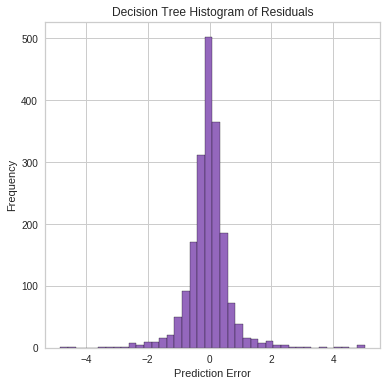

In [ ]:
plot_residuals_histogram(y_test, predicted_dt, 'Decision Tree Histogram of Residuals', colour = 'tab:purple')

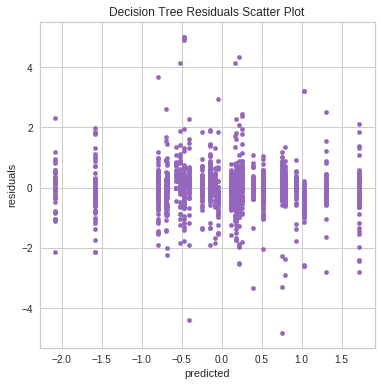

In [ ]:
plot_residuals_scatter(y_test, predicted_dt, 'Decision Tree Residuals Scatter Plot', colour = 'tab:purple')

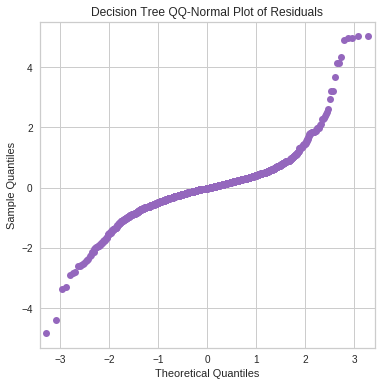

In [ ]:
plot_qq(y_test, predicted_dt, 'Decision Tree QQ-Normal Plot of Residuals', colour = 'tab:purple')

### 2.3 Random Forest

In [ ]:
parameters_cv_rf = {
  'bootstrap': [True],
  'n_estimators': [trees for trees in range(100, 2000, 50)],
  'max_depth': [depth for depth in range(10, 500, 10)],
  'min_samples_leaf': range(2, 100, 5),
  'min_samples_split': [sample for sample in range(2, 500, 50)],
  'max_features': [degree_freedom for degree_freedom in range(2, 37, 5)]
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

rf_model = RandomForestRegressor(random_state = 42)

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(rf_model, 
                                   param_distributions = parameters_cv_rf, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed: 14.2min remaining: 114.9min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed: 18.0min remaining: 63.9min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed: 24.9min remaining: 50.5min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed: 28.6min remaining: 36.4min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed: 30.5min remaining: 25.0min
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed: 32.6min remaining: 16.8min
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed: 36.6min remaining: 10.9min
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed: 37.1min remaini

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6663cebc50>,
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimato...
                                        'min_samples_leaf': range(2, 100, 5),
    

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.8064734398131965

 Best hyperparameters:
{'n_estimators': 1450, 'min_samples_split': 52, 'min_samples_leaf': 7, 'max_features': 32, 'max_depth': 460, 'bootstrap': True}


In [ ]:
rf_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=460,
                      max_features=32, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=52,
                      min_weight_fraction_leaf=0.0, n_estimators=1450,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [ ]:
predicted_rf = rf_model.predict(X_test)

In [ ]:
metrics_rf = compute_metrics(y_test, predicted_rf)

Maximum residuals error: 4.966866584425329
Mean squared error: 0.4554648186102677
Mean absolute error: 0.37203432879060117
R-squared score: 0.5475480396067924
Explained variance: 0.547967672134122


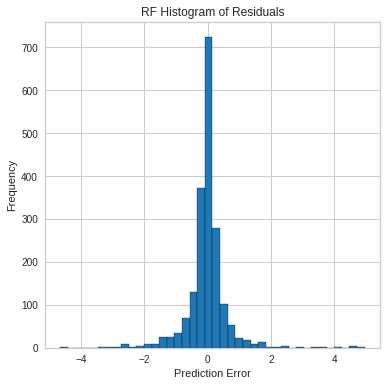

In [ ]:
plot_residuals_histogram(y_test, predicted_rf, 'RF Histogram of Residuals')

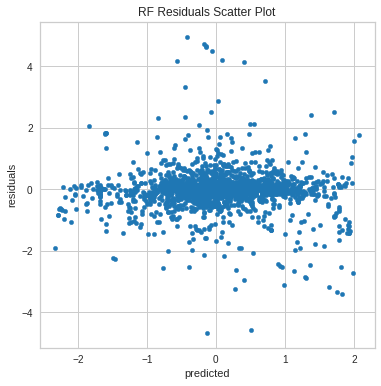

In [ ]:
plot_residuals_scatter(y_test, predicted_rf, 'RF Residuals Scatter Plot')

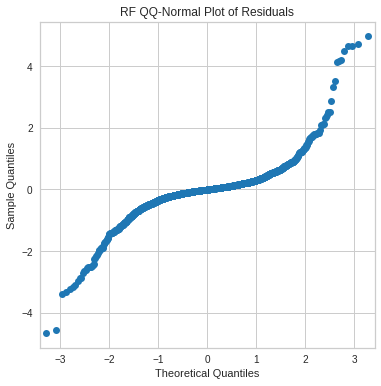

In [ ]:
plot_qq(y_test, predicted_rf, 'RF QQ-Normal Plot of Residuals')

### 2.4 Boosted Trees

In [ ]:
parameters_cv_xgb = {
  'booster': ['gbtree', 'gblinear', 'dart'],
  'eta': [0.3, 0.2, 0.1, 0.01, 0.001, 0.0005, 0.0003, 0.0001],
  'max_depth': [depth for depth in range(10, 1000, 10)],
  'max_leaves': [i for i in range(8)],
  'max_delta_step': [i for i in range(10)],
  'gamma': [i / 2 for i in range(1, 20)],
  'subsample': [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0],
  'colsample_bytree': [sample / 100 for sample in range(10, 100, 1)],
  'colsample_bylevel': [sample / 100 for sample in range(10, 100, 1)],
  'colsample_bynode': [sample / 100 for sample in range(10, 100, 1)],
  'eval_metric': ['rmse', 'mae', 'logloss'],
  'objective': ['reg:squarederror'],
  'tree_method': ['auto', 'exact']
}

In [ ]:
features = indicators_fn.drop(['CountryName', 'GDP growth (annual %)'], axis = 1)

labels = indicators_fn['GDP growth (annual %)'].values

xgb_model = XGBRegressor()

kf = KFold(n_splits = 10, shuffle = False, random_state = 1001)

random_search = RandomizedSearchCV(xgb_model, 
                                   param_distributions = parameters_cv_xgb, 
                                   n_iter = 10, 
                                   scoring = 'neg_mean_squared_error', 
                                   n_jobs = 100, 
                                   cv = kf.split(features, labels), 
                                   verbose = 10, 
                                   random_state = 1001)

random_search.fit(features, labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:   51.7s remaining:  7.0min
[Parallel(n_jobs=100)]: Done  22 out of 100 | elapsed:   54.0s remaining:  3.2min
[Parallel(n_jobs=100)]: Done  33 out of 100 | elapsed:  1.5min remaining:  3.1min
[Parallel(n_jobs=100)]: Done  44 out of 100 | elapsed:  1.6min remaining:  2.0min
[Parallel(n_jobs=100)]: Done  55 out of 100 | elapsed:  2.3min remaining:  1.8min
[Parallel(n_jobs=100)]: Done  66 out of 100 | elapsed:  3.3min remaining:  1.7min
[Parallel(n_jobs=100)]: Done  77 out of 100 | elapsed:  4.2min remaining:  1.2min
[Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:  4.6min remaining:   37.7s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:  4.6min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f6669f80db0>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs...
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
              

In [ ]:
print('Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (10, 10))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Best estimator:
XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.63,
             colsample_bynode=0.87, colsample_bytree=0.64, eta=0.0005,
             eval_metric='rmse', gamma=6.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=8, max_depth=820, max_leaves=4,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='exact', verbosity=1)

 Best normalized gini score for 10-fold search with 10 parameter combinations:
-1.746780257331713

 Best hyperparameters:
{'tree_method': 'exact', 'subsample': 0.6, 'objective': 'reg:squarederror', 'max_leaves': 4, 'max_depth': 820, 'max_delta_step': 8, 'gamma': 6.0, 'eval_metric': 'rmse', 'eta': 0.0005, 'colsample_bytree': 0.64, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.63, 'booster': 'dart'

In [ ]:
xgb_model = XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.63,
             colsample_bynode=0.87, colsample_bytree=0.64, eta=0.0005,
             eval_metric='rmse', gamma=6.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=8, max_depth=820, max_leaves=4,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='exact', verbosity=1)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=0.63,
             colsample_bynode=0.87, colsample_bytree=0.64, eta=0.0005,
             eval_metric='rmse', gamma=6.0, importance_type='gain',
             learning_rate=0.1, max_delta_step=8, max_depth=820, max_leaves=4,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, tree_method='exact', verbosity=1)

In [ ]:
predicted_xgb = xgb_model.predict(X_test)

In [ ]:
metrics_xgb = compute_metrics(y_test, predicted_xgb)

Maximum residuals error: 4.709812183740662
Mean squared error: 0.40247936599783896
Mean absolute error: 0.36676028812365485
R-squared score: 0.60018299828475
Explained variance: 0.6002207848041656


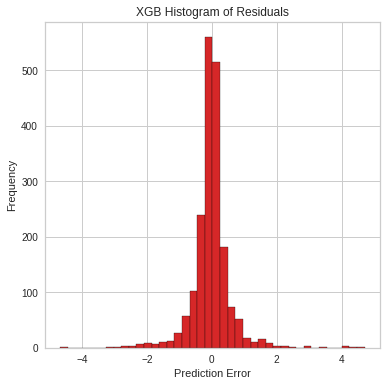

In [ ]:
plot_residuals_histogram(y_test, predicted_xgb, 'XGB Histogram of Residuals', colour = 'tab:red')

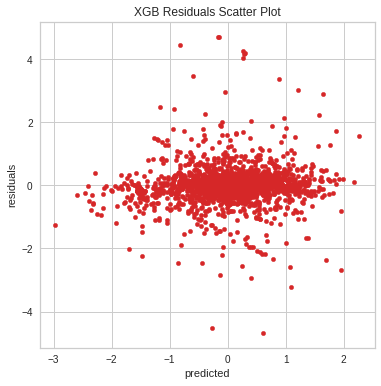

In [ ]:
plot_residuals_scatter(y_test, predicted_xgb, 'XGB Residuals Scatter Plot', colour = 'tab:red')

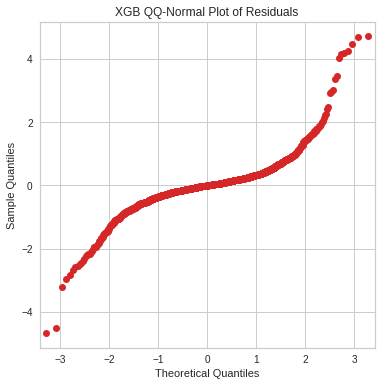

In [ ]:
plot_qq(y_test, predicted_xgb, 'XGB QQ-Normal Plot of Residuals', colour = 'tab:red')

### Plot Metrics

In [ ]:
np.array([np.array(metrics_lm), 
         np.array(metrics_dt), 
         np.array(metrics_rf), 
         np.array(metrics_xgb)])

metrics = pd.DataFrame(data = np.array([np.array(metrics_lm), 
                              np.array(metrics_dt), 
                              np.array(metrics_rf), 
                              np.array(metrics_xgb)]), 
                       columns = ['Maximum Residual Error', 
                                  'Mean Squared Error',
                                  'Mean Absolute Error',
                                  'R^2 Score',
                                  'Explained Variance'], 
                       index = ['Linear Model', 
                                'Decision Tree', 
                                'Random Forest', 
                                'XGBoost'])

metrics

Maximum Residual Error  ...  Explained Variance
Linear Model                 4.974216  ...            0.601615
Decision Tree                5.013004  ...            0.497784
Random Forest                4.966867  ...            0.547968
XGBoost                      4.709812  ...            0.600221

[4 rows x 5 columns]

### Plot Real vs Predicted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


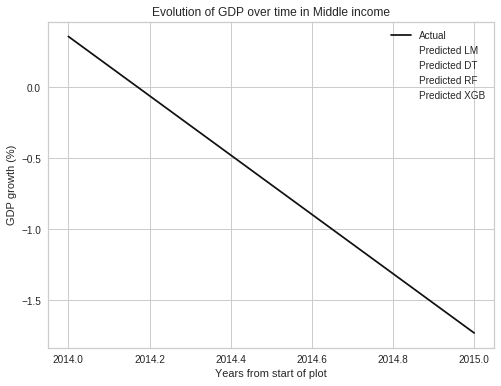

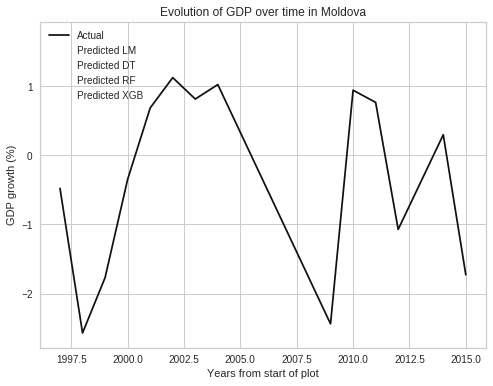

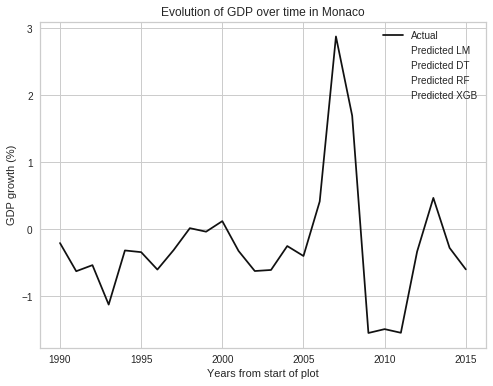

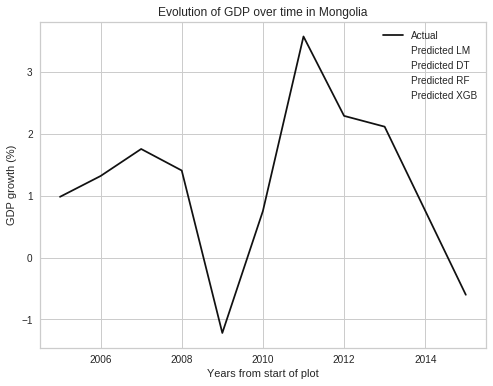

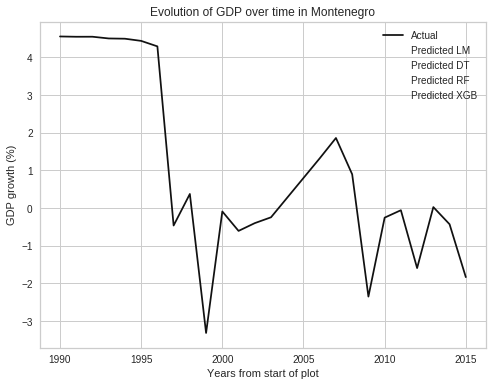

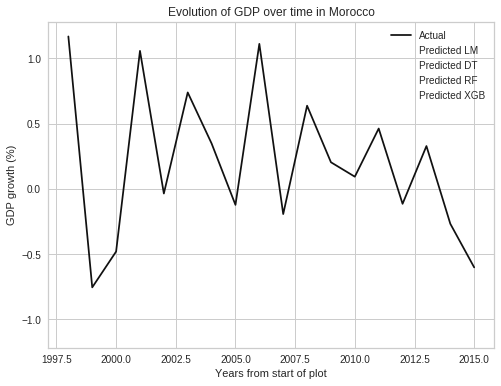

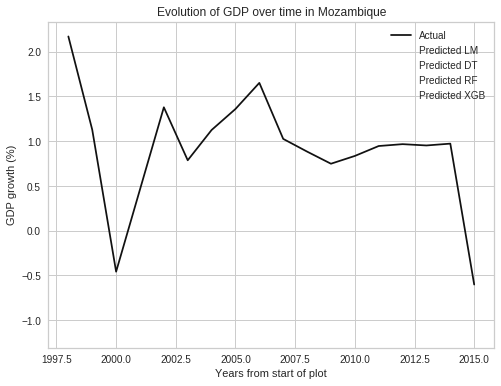

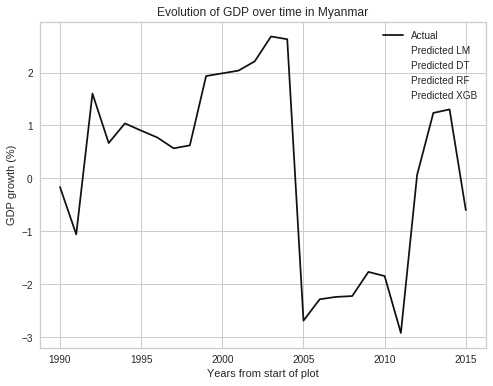

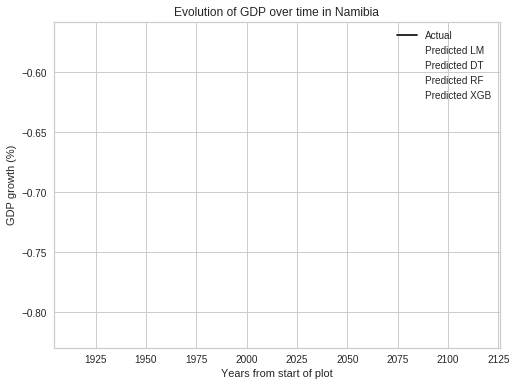

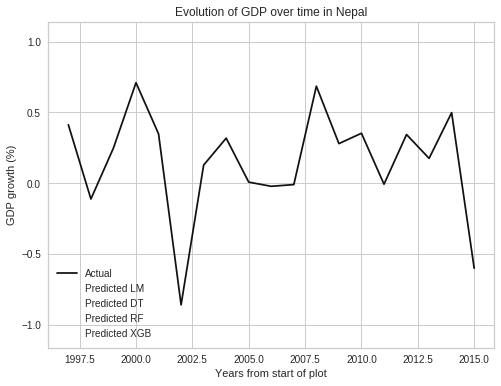

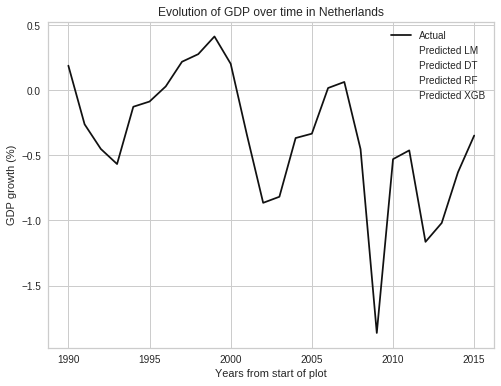

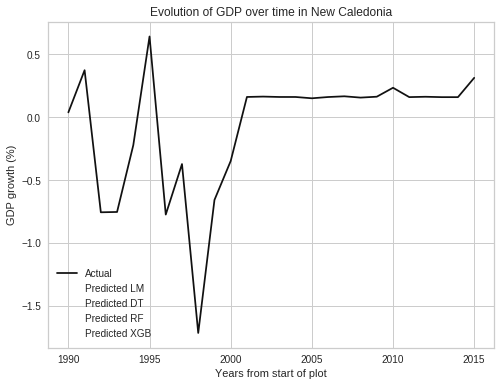

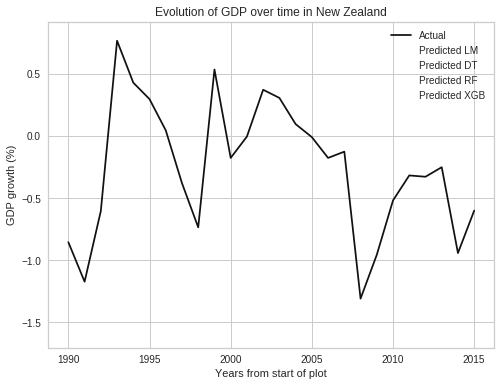

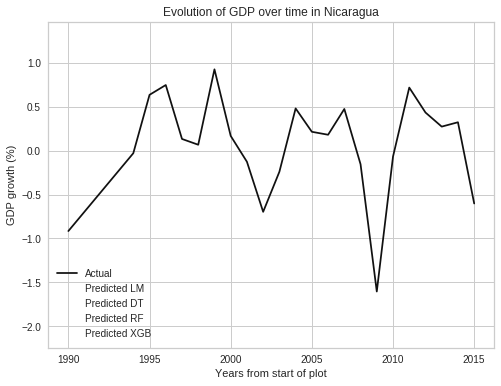

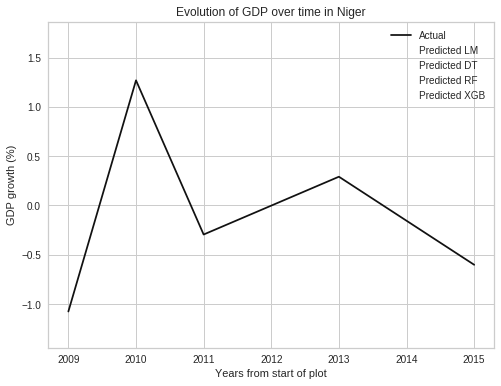

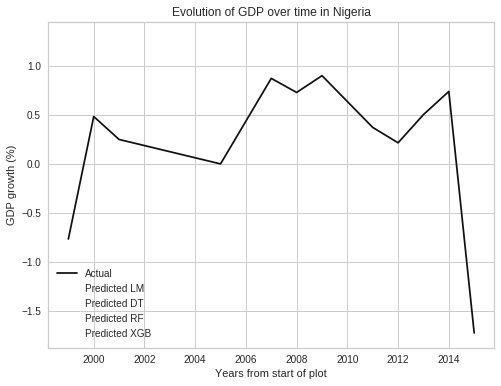

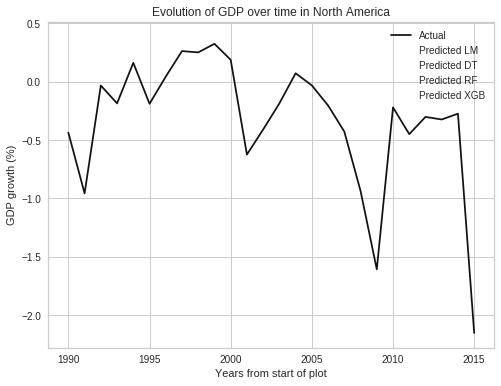

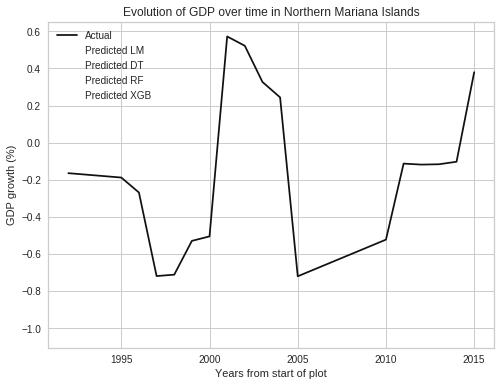

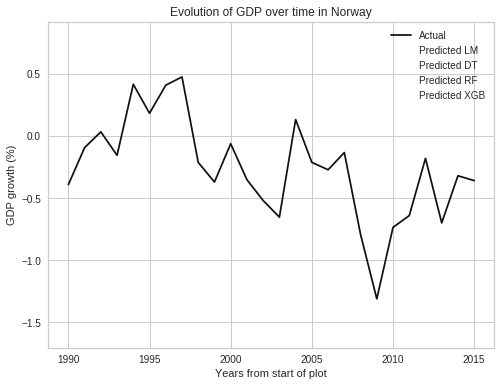

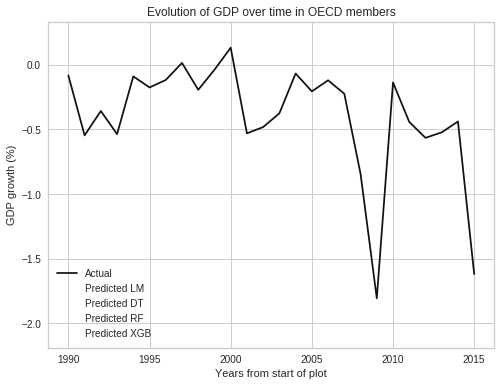

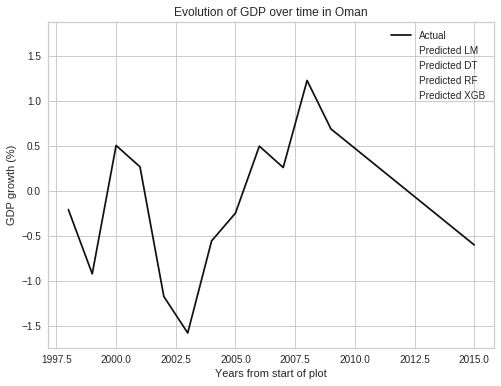

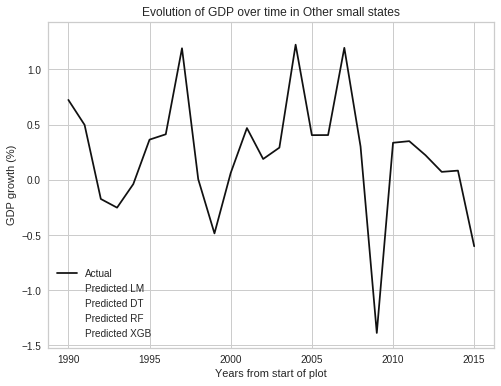

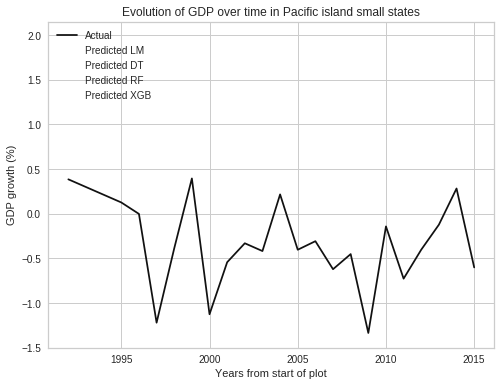

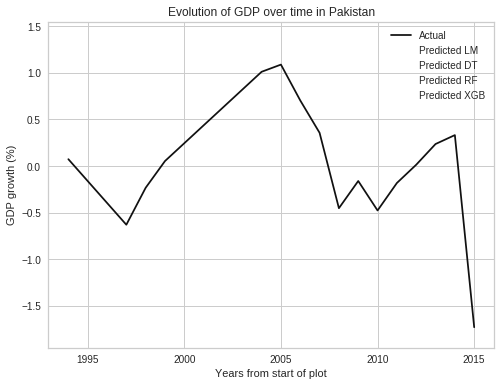

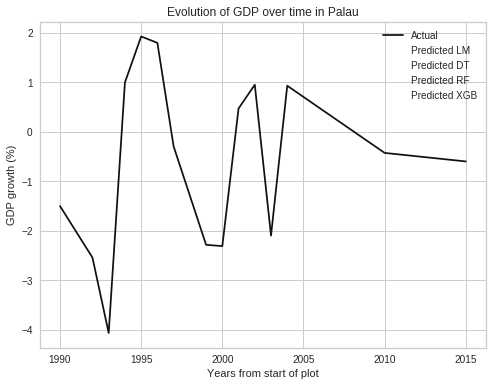

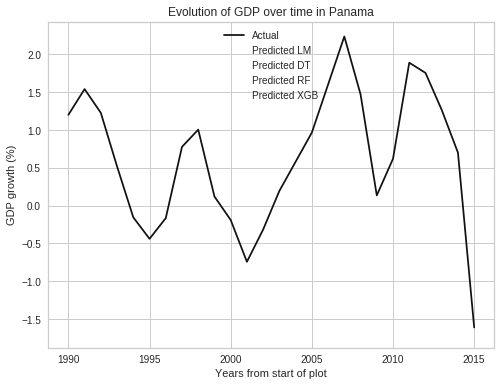

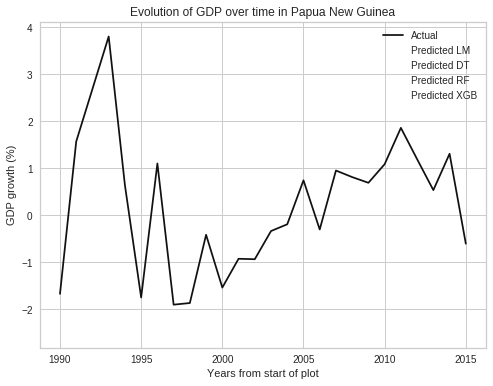

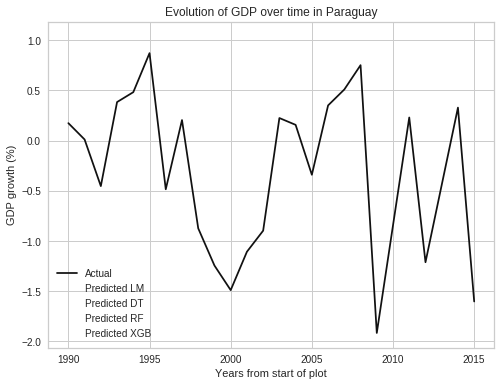

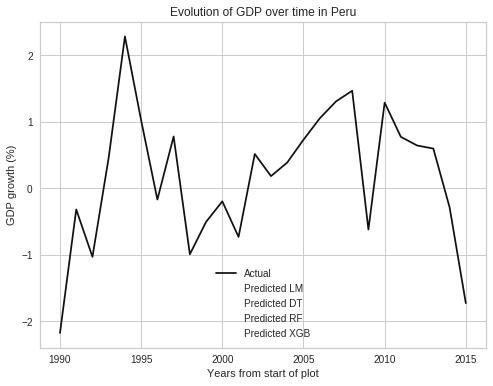

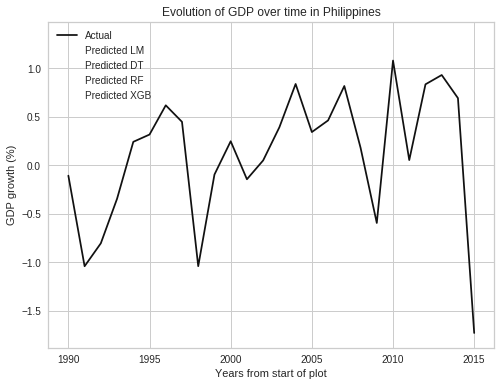

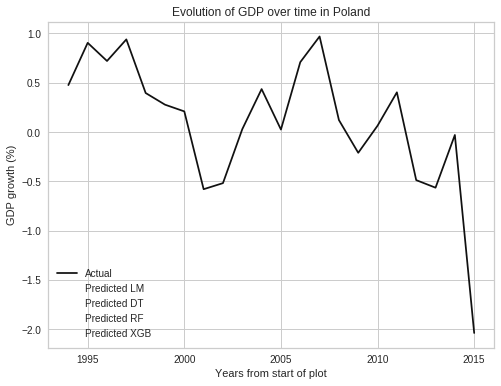

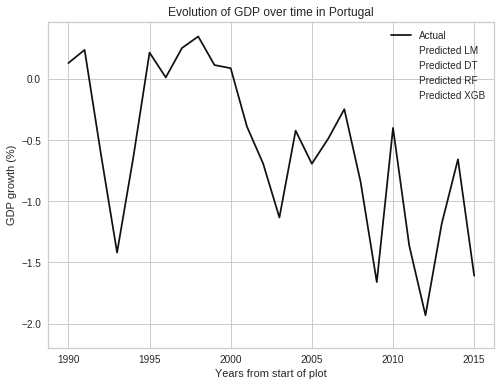

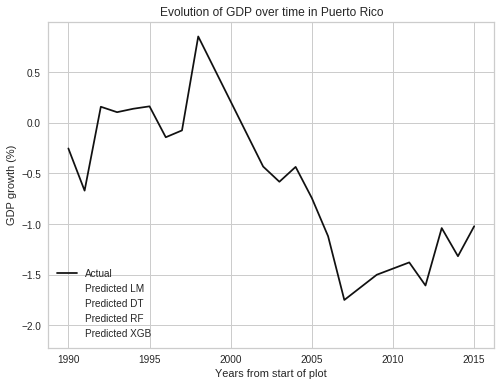

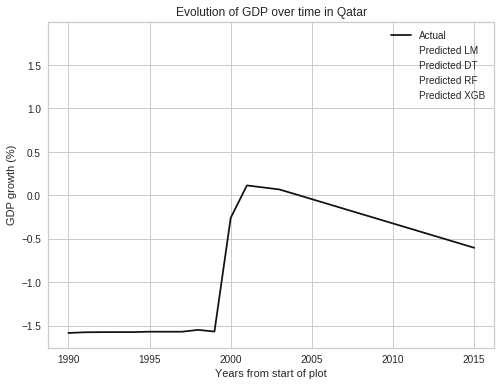

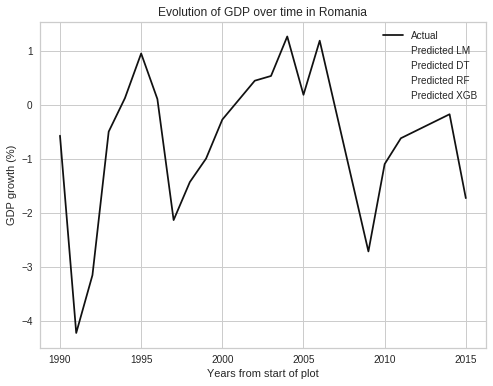

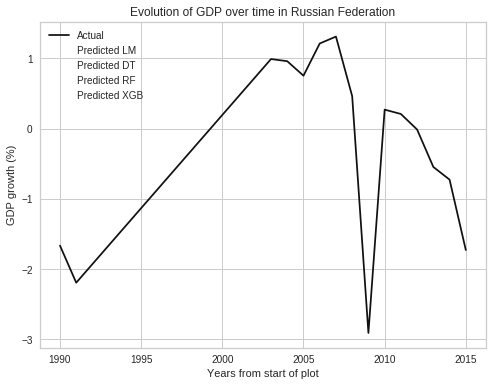

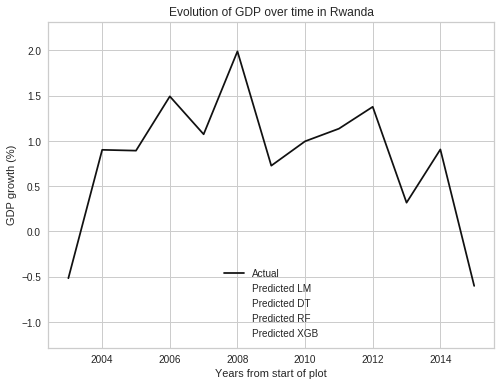

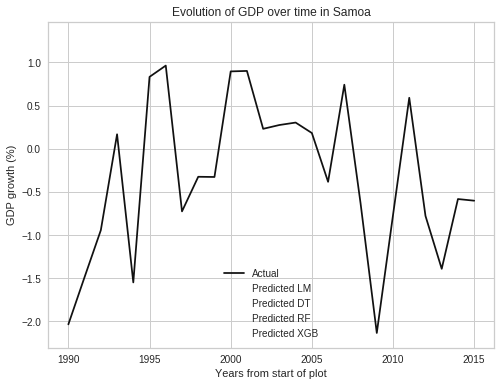

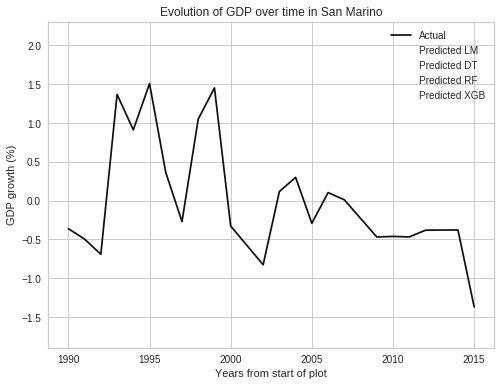

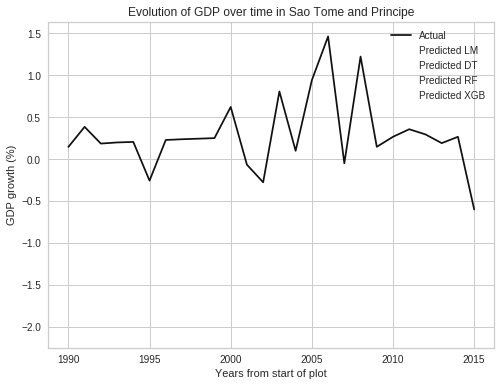

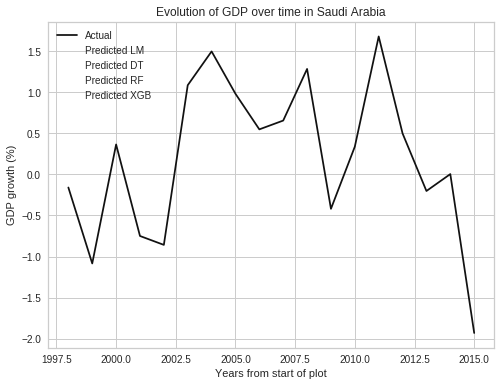

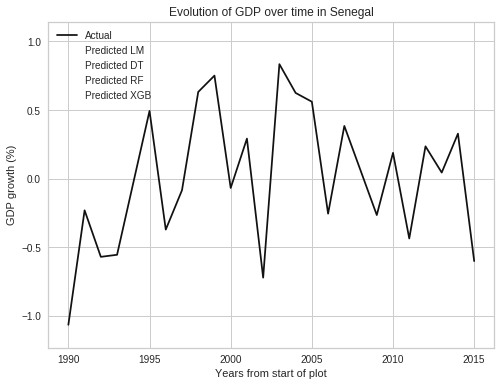

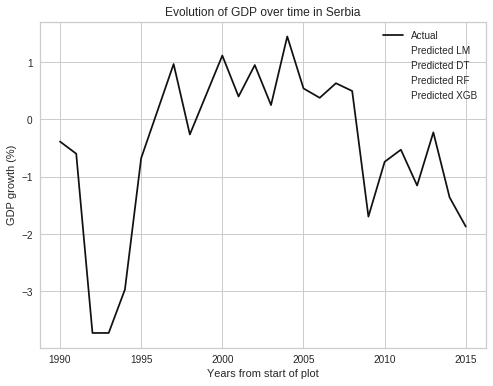

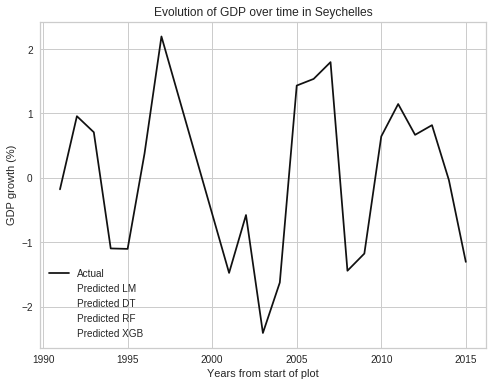

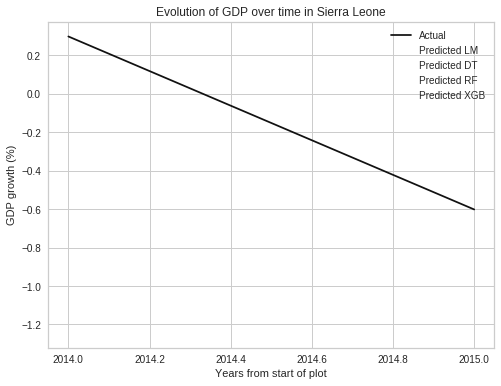

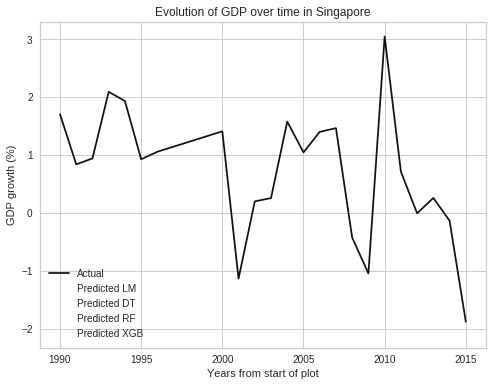

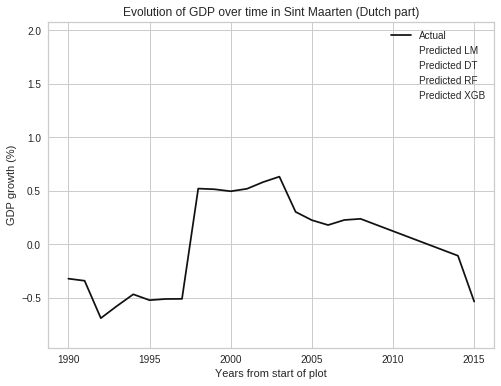

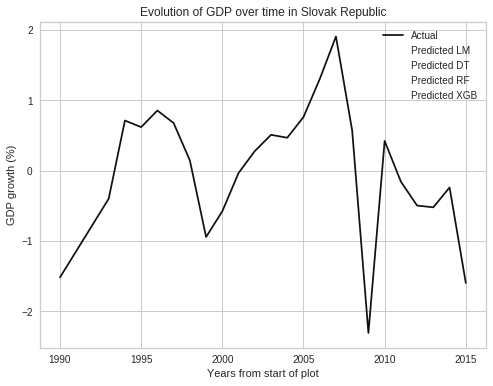

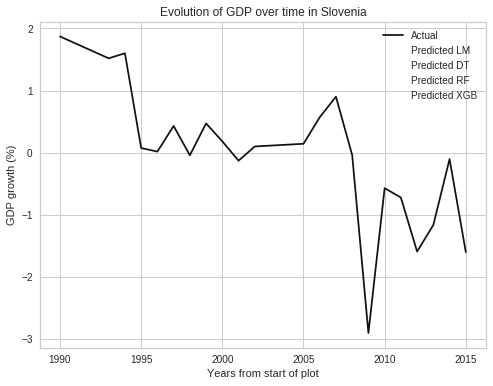

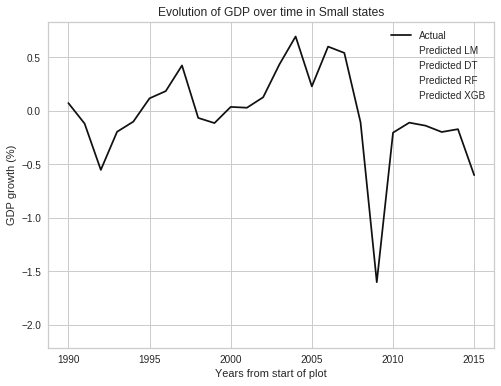

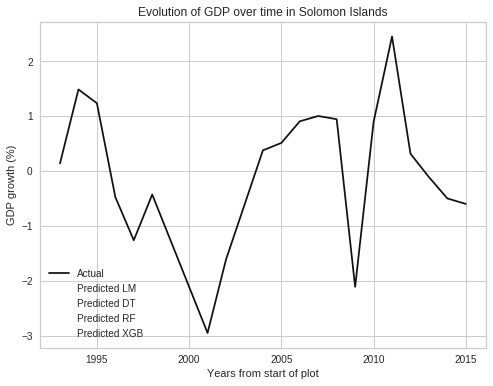

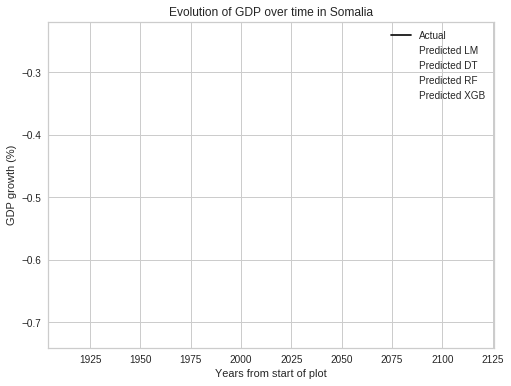

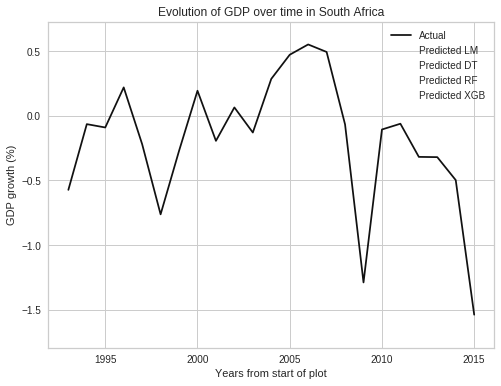

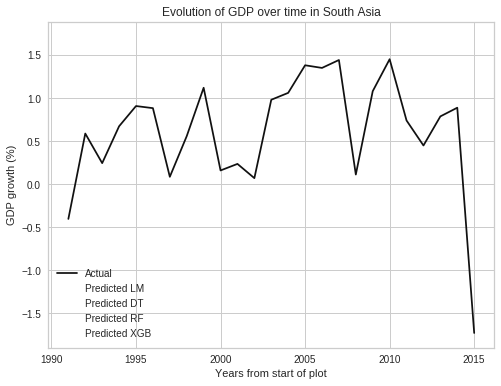

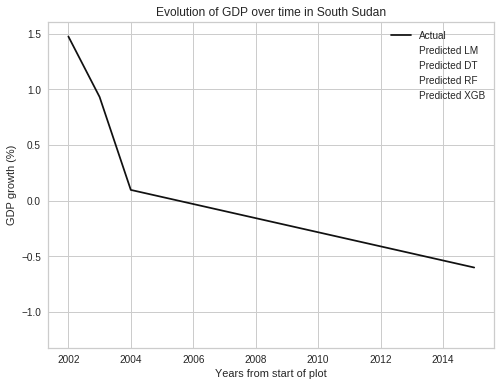

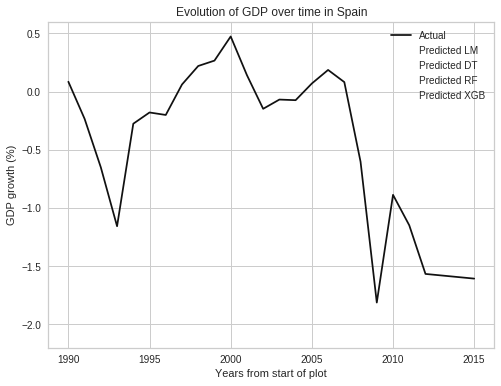

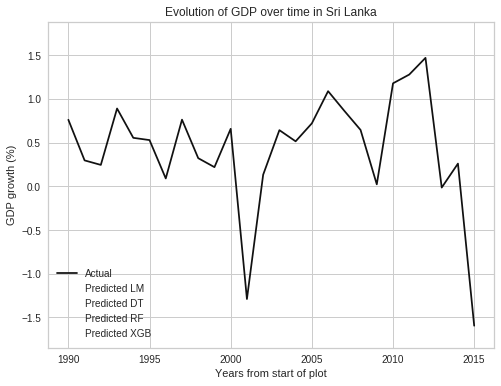

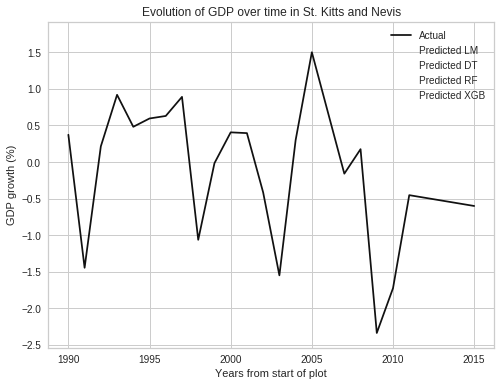

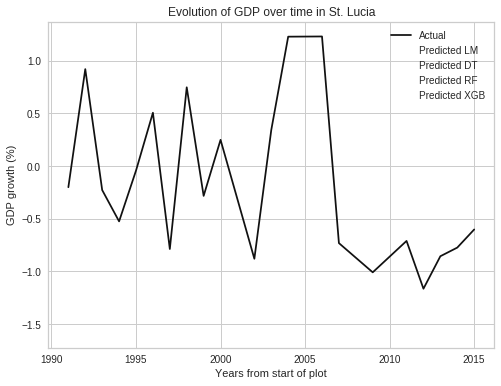

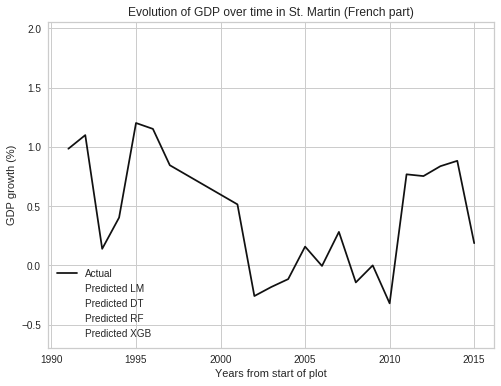

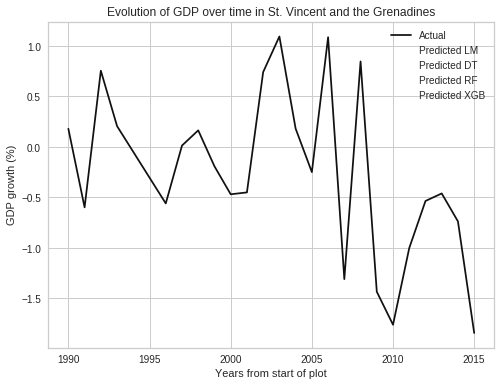

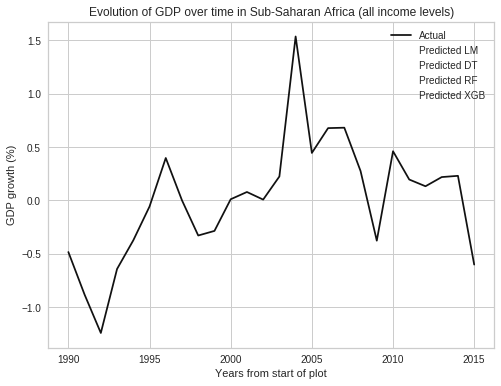

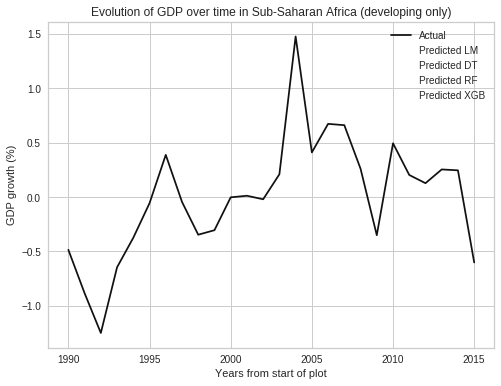

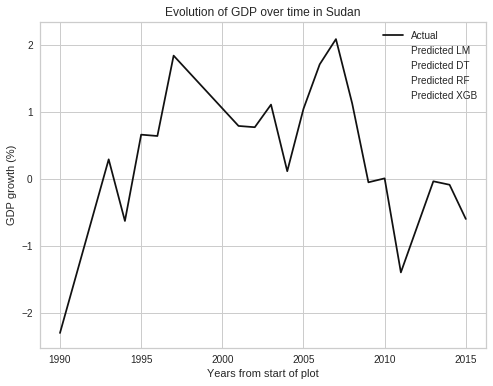

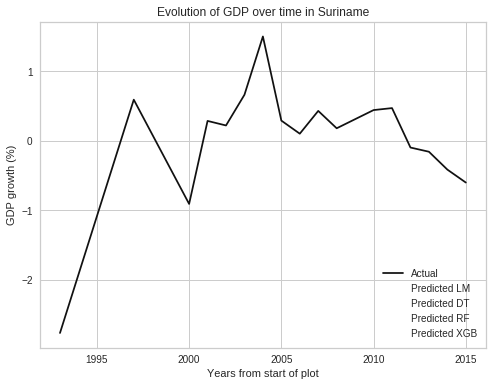

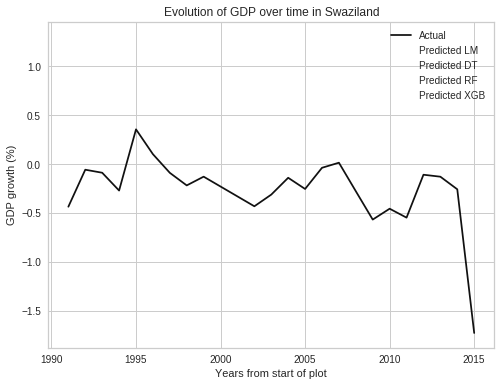

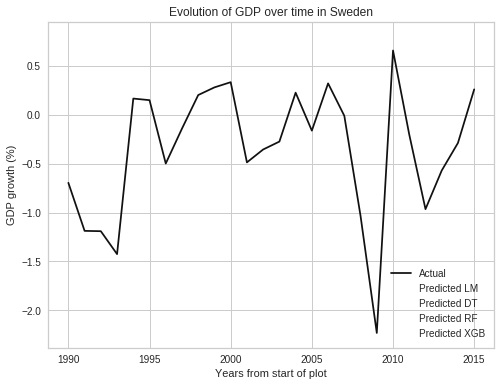

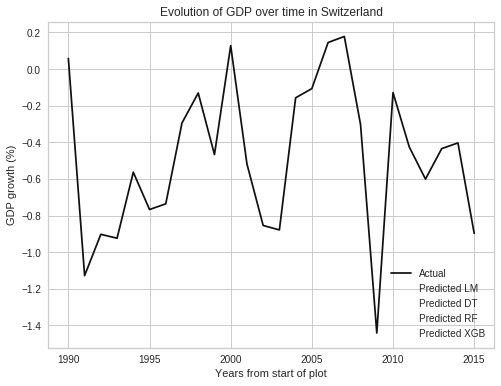

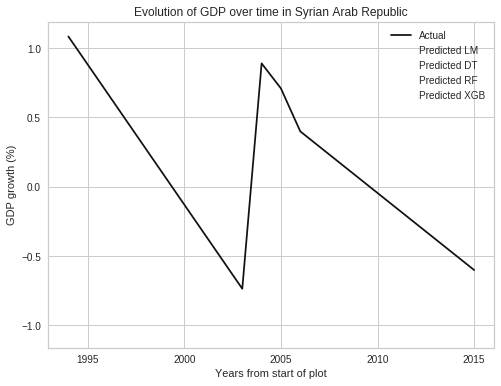

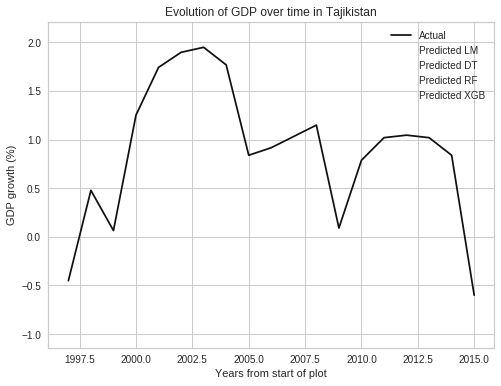

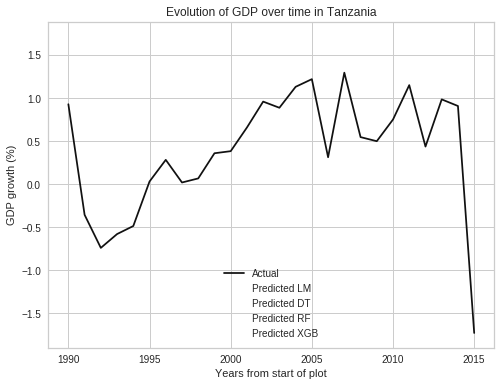

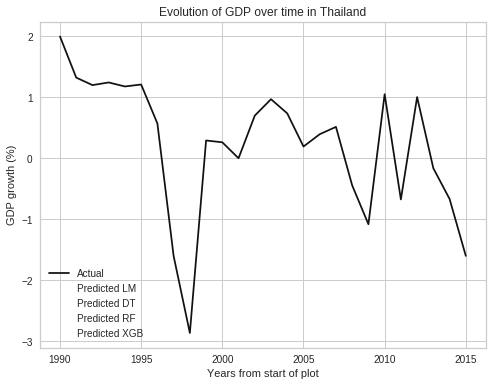

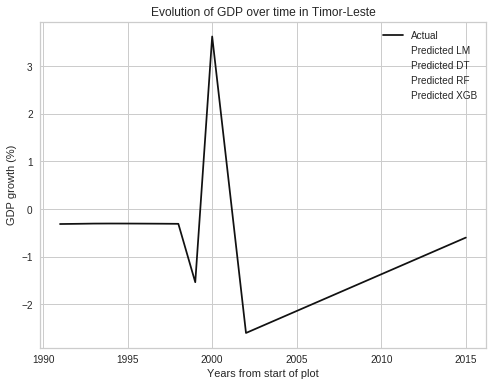

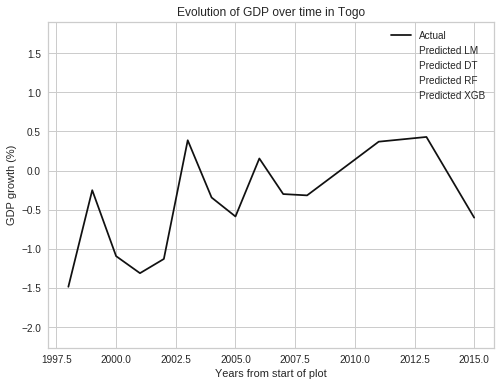

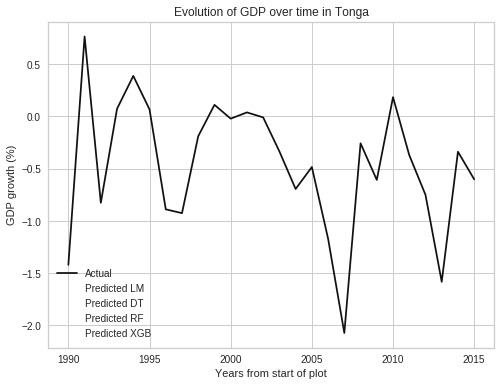

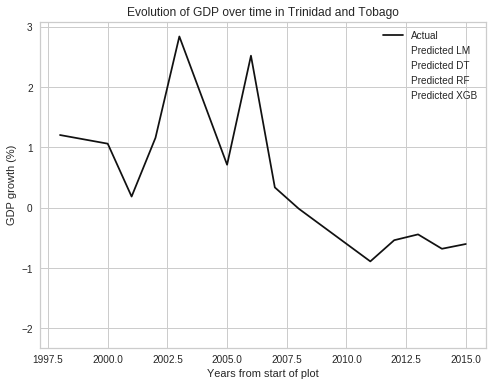

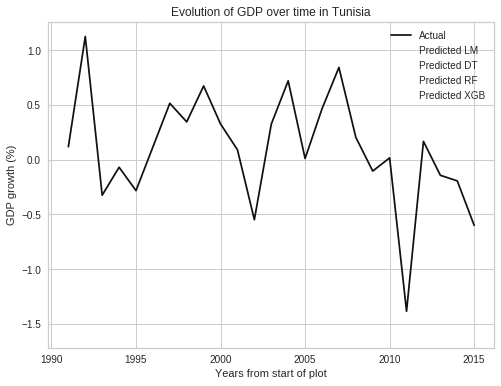

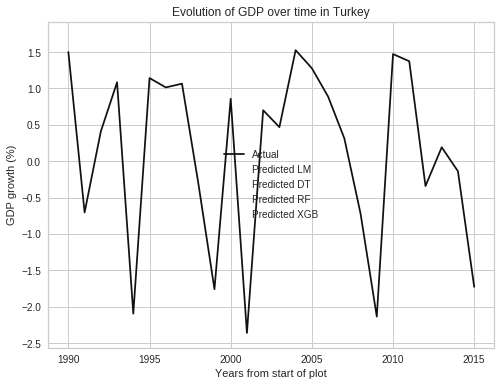

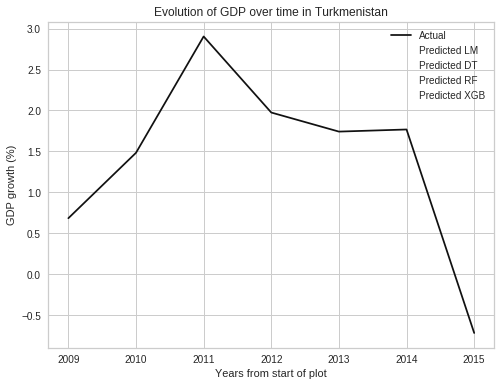

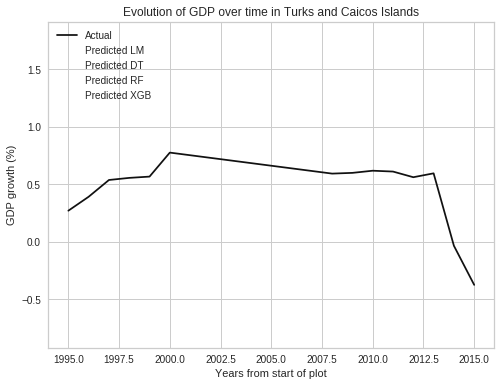

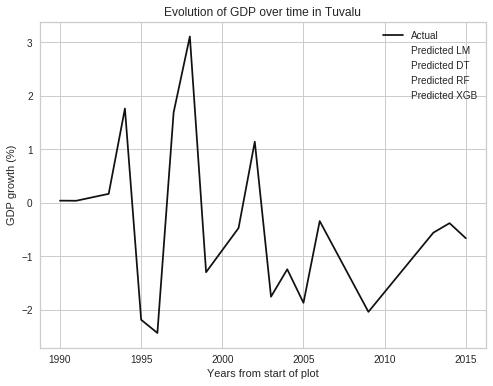

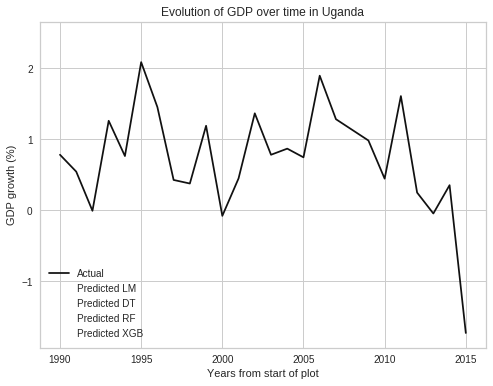

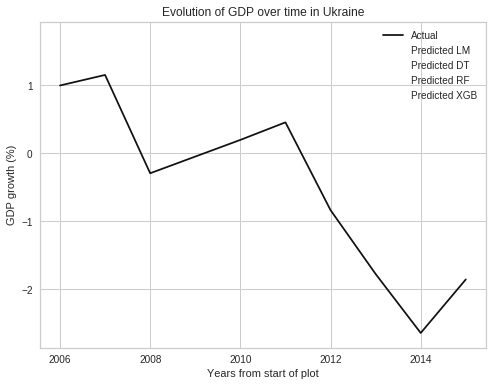

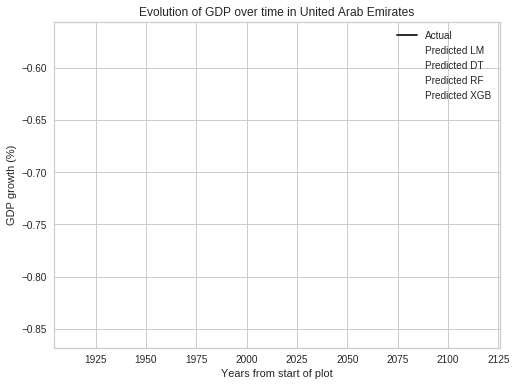

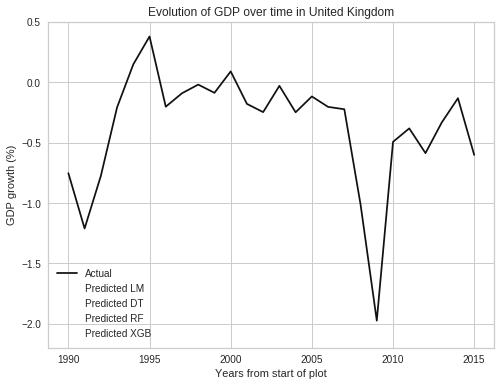

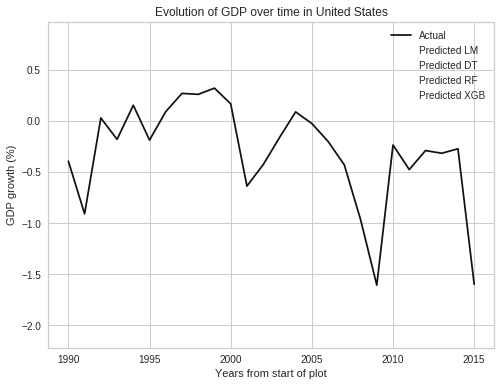

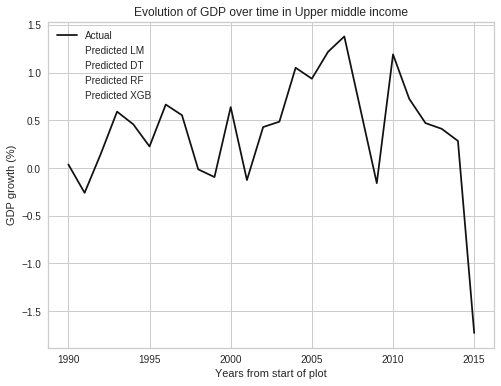

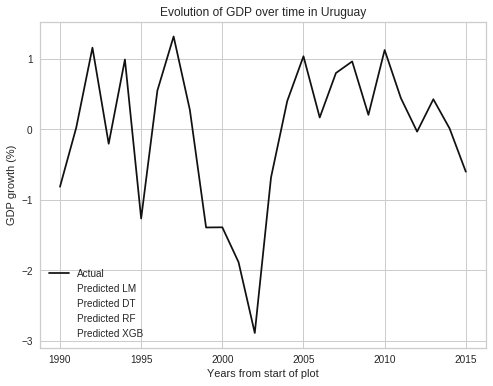

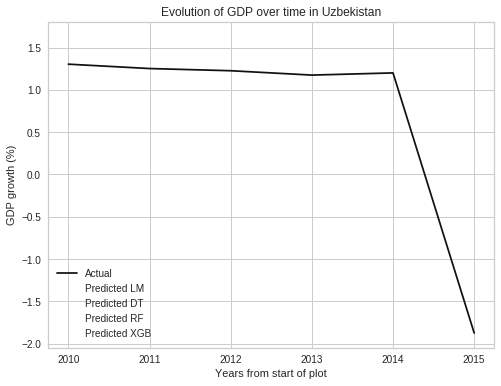

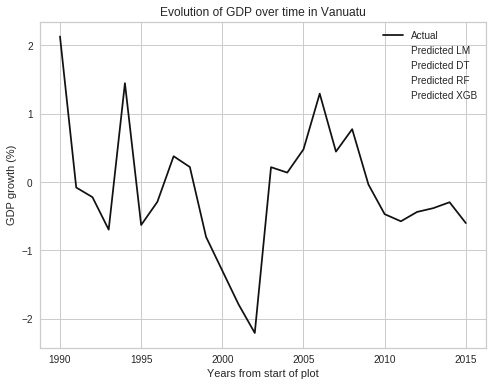

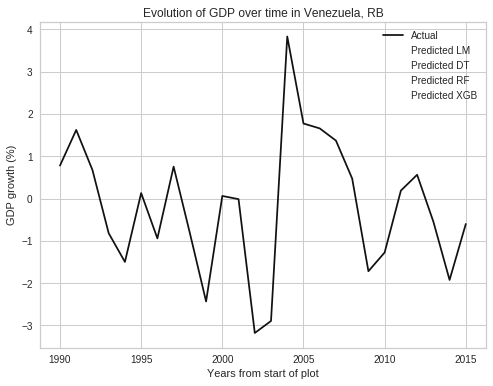

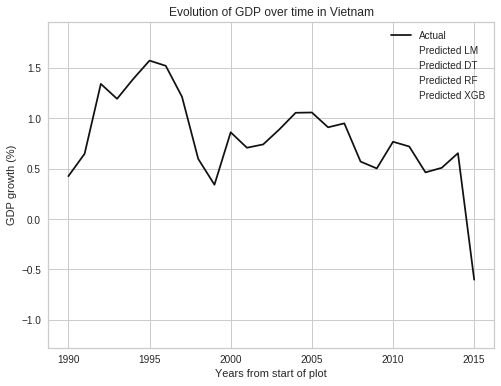

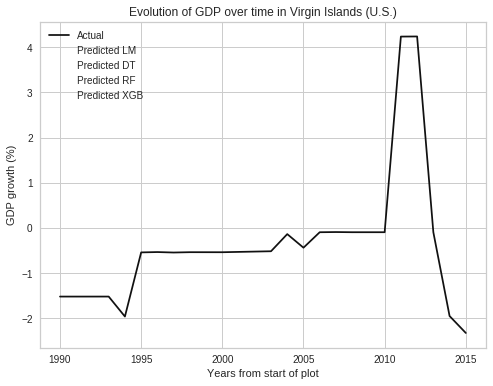

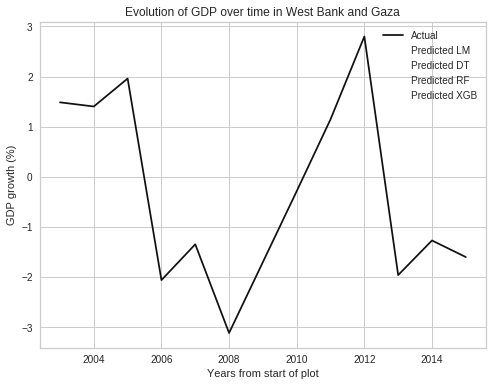

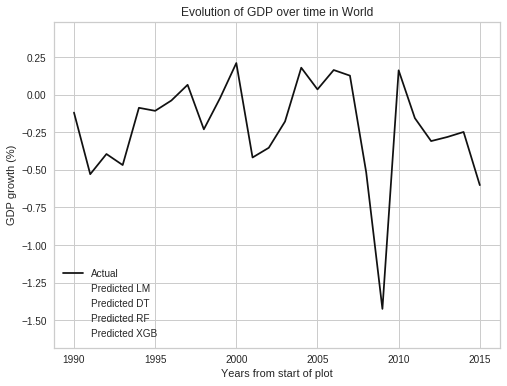

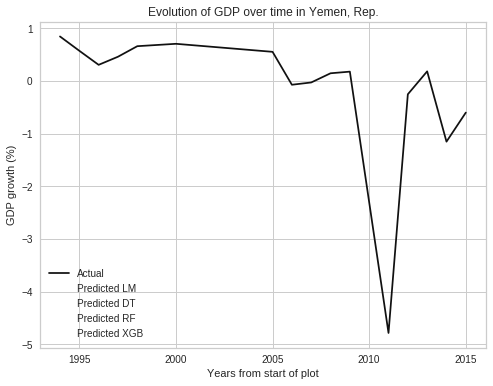

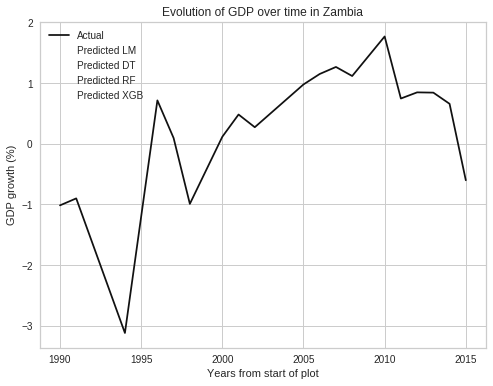

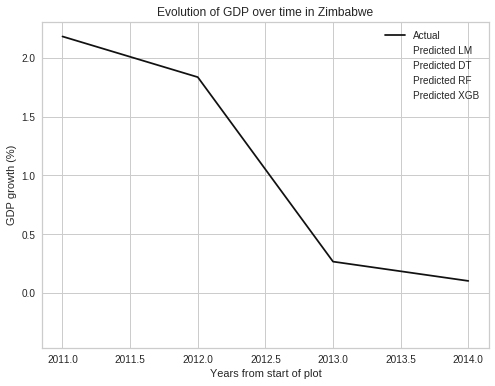

In [ ]:
predictions = pd.DataFrame({'CountryName': indicators_fn[3017:]['CountryName'],
                            'Year': indicators_fn[3017:]['Year'],
                            'GDP growth (annual %)': indicators_fn[3017:]['GDP growth (annual %)'],
                            'Predicted LM': predicted_lm,
                            'Predicted DT': predicted_dt,
                            'Predicted RF': predicted_rf,
                            'Predicted XGB': predicted_xgb})

plot_predictions(predictions)

## 3. Use PCA in order to perform feature selection

I have initially intended to add PCA too in the report, but the results form the previous two models were on a whole other level when compared to this one. However, I have kept it in the project for anyone who is interested in comparing PCA with Random Forest or Lasso.

In [ ]:
indicators_knn_imputed = pd.read_csv('/content/gdrive/My Drive/An 1 Masters/EDA/indicators_knn_imputed.csv')

In [ ]:
X_train = indicators_knn_imputed.drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)

country_names = indicators_knn_imputed['CountryName']
years = indicators_knn_imputed['Year']
gdp_growth = indicators_knn_imputed['GDP growth (annual %)']

In [ ]:
pca = PCA(0.99)

principal_components = pca.fit_transform(X_train)

principal_df = pd.DataFrame(data = principal_components)

In [ ]:
indicators_filtered = pd.DataFrame({'CountryName': country_names,
                                    'Year': years,
                                    'GDP growth (annual %)': gdp_growth,
                                    'Component 1': principal_df[principal_df.columns[0]],
                                    'Component 2': principal_df[principal_df.columns[1]],
                                    'Component 3': principal_df[principal_df.columns[2]],
                                    'Component 4': principal_df[principal_df.columns[3]]})

In [ ]:
unique_country_names = indicators_filtered['CountryName'].unique()

cn_map = {}

i = 0

for cn in unique_country_names:
  if cn not in cn_map:
    cn_map[cn] = i
    i += 1

inv_cn_map = {v: k for k, v in cn_map.items()}

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(cn_map)

In [ ]:
indicators_filtered = indicators_filtered[(np.abs(zscore(indicators_filtered)) < 3).all(axis=1)]

indicators_filtered['CountryName'] = indicators_filtered['CountryName'].map(inv_cn_map)

In [ ]:
columns_fn = indicators_filtered.columns[1:]

country_names = indicators_filtered['CountryName']

years = indicators_filtered['Year']

scaler = StandardScaler()

scaler.fit(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

scaled_indicators = scaler.transform(indicators_filtered.drop(labels = ['CountryName'], axis = 1))

In [ ]:
indicators_fn = pd.DataFrame(data = scaled_indicators, columns = columns_fn)

indicators_fn['Year'] = years.values

indicators_fn.insert(0, value = country_names.values, column = 'CountryName')

indicators_fn['CountryName'] = indicators_fn['CountryName'].map(inv_cn_map)

In [ ]:
indicators_fn.shape

(6247, 7)

### 3.1 Linear Model

In [ ]:
X_train = indicators_fn[:4370].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_train = indicators_fn[:4370]['GDP growth (annual %)']
X_test = indicators_fn[4370:].drop(labels = ['CountryName', 'GDP growth (annual %)'], axis = 1)
y_test = indicators_fn[4370:]['GDP growth (annual %)']

In [ ]:
lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
predicted_lm = lm_model.predict(X_test)

In [ ]:
compute_metrics(y_test, predicted_lm)

Mean squared error: 1.0673923713795859
Mean absolute error: 0.7540506975533914
R-square metric: 0.0012811146920038707


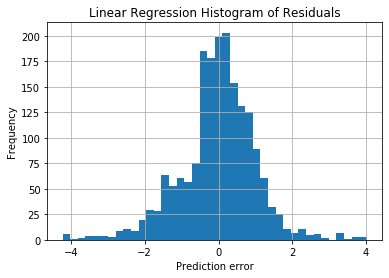

In [ ]:
plot_residuals_histogram(y_test, predicted_lm, 'Linear Regression Histogram of Residuals')

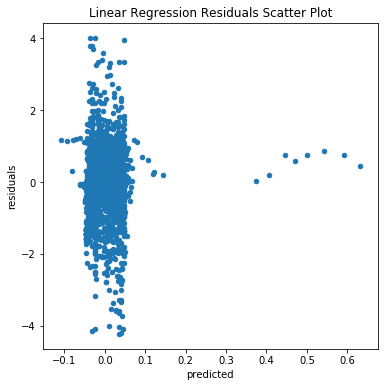

In [ ]:
plot_residuals_scatter(y_test, predicted_lm, 'Linear Regression Residuals Scatter Plot')

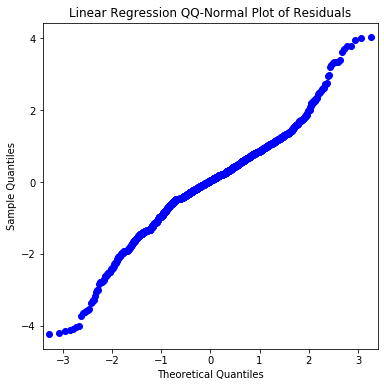

In [ ]:
plot_qq(y_test, predicted_lm, 'Linear Regression QQ-Normal Plot of Residuals')